In [ ]:
"""
To make sure the fusion decomposition works
up to the part where we would stitch the sublimbs together into one limb


"""

In [1]:
from os import sys
sys.path.append("/meshAfterParty/")

In [2]:
import skeleton_utils as sk
import soma_extraction_utils as sm
import trimesh_utils as tu
import trimesh
import numpy_utils as nu
import numpy as np
from importlib import reload
import networkx as nx
import time
import compartment_utils as cu
import networkx_utils as xu
import matplotlib_utils as mu
import neuron_utils as nru

#importing at the bottom so don't get any conflicts
import itertools
from tqdm_utils import tqdm

#for meshparty preprocessing
import meshparty_skeletonize as m_sk
import general_utils as gu
import compartment_utils as cu
from meshparty import trimesh_io
from copy import deepcopy


from neuron_utils import *


# Loading the Neuron

In [3]:
import trimesh_utils as tu
curent_neuron = tu.load_mesh_no_processing("/notebooks/test_neurons/Segmentation_2/3_soma.off")
segment_id = 1357
description = "triple_soma"

In [4]:
import neuron_visualizations as nviz
nviz.plot_objects(main_mesh=curent_neuron)

/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


# Setting the Arguments that would be present inside a preprocessing function call

In [5]:
#predefined arguments for the Neuron constructor

decomposition_type="meshafterparty"
mesh_correspondence="meshparty" #meshafterparty_adaptive
distance_by_mesh_center=True #how the distance is calculated for mesh correspondence
meshparty_segment_size = 100
meshparty_n_surface_downsampling = 2
meshparty_adaptive_correspondence_after_creation=False
suppress_preprocessing_print=True
computed_attribute_dict=None
somas = None
branch_skeleton_data=None
combine_close_skeleton_nodes = True
combine_close_skeleton_nodes_threshold=700
ignore_warnings=True
suppress_output=False
calculate_spines=True
widths_to_calculate=["no_spine_median_mesh_center",
                "no_spine_mean_mesh_center"]
fill_hole_size=2000

In [6]:
#arguments for the preprocess neuron
mesh = curent_neuron
segment_id=segment_id
description=description

sig_th_initial_split=15 #for significant splitting meshes in the intial mesh split
limb_threshold = 2000 #the mesh faces threshold for a mesh to be qualified as a limb (otherwise too small)
filter_end_node_length=4001 #used in cleaning the skeleton during skeletonizations
return_no_somas = False

decomposition_type=decomposition_type
mesh_correspondence=mesh_correspondence
distance_by_mesh_center=distance_by_mesh_center
meshparty_segment_size =meshparty_segment_size
meshparty_n_surface_downsampling = meshparty_n_surface_downsampling
somas=somas
branch_skeleton_data=branch_skeleton_data
combine_close_skeleton_nodes = combine_close_skeleton_nodes
combine_close_skeleton_nodes_threshold=combine_close_skeleton_nodes_threshold

# Setting up the metadata

In [7]:
whole_processing_tiempo = time.time()


"""
Purpose: To process the mesh into a format that can be loaded into the neuron class
and used for higher order processing (how to visualize is included)

"""
if description is None:
    description = "no_description"
if segment_id is None:
    #pick a random segment id
    segment_id = np.random.randint(100000000)
    print(f"picking a random 7 digit segment id: {segment_id}")
    description += "_random_id"


if mesh is None:
    if current_mesh_file is None:
        raise Exception("No mesh or mesh_file file were given")
    else:
        current_neuron = trimesh.load_mesh(current_mesh_file)
else:
    current_neuron = mesh

# ************************ Phase A: Soma and Limb Identification ********************************

In [8]:
# --- 1) Doing the soma detection
if somas is None:
    soma_mesh_list,run_time,total_soma_list_sdf = sm.extract_soma_center(segment_id,
                                             current_neuron.vertices,
                                             current_neuron.faces)
else:
    soma_mesh_list,run_time,total_soma_list_sdf = somas

# geting the soma centers
if len(soma_mesh_list) <= 0:
    print(f"**** No Somas Found for Mesh {segment_id} so just one mesh")
    soma_mesh_list_centers = []
    if return_no_somas:
        return_value= soma_mesh_list_centers
    raise Exception("Processing of No Somas is not yet implemented yet")
else:
    #compute the soma centers
    print(f"Soma List = {soma_mesh_list}")

    soma_mesh_list_centers = sm.find_soma_centroids(soma_mesh_list)
    print(f"soma_mesh_list_centers = {soma_mesh_list_centers}")

Current Arguments Using (adjusted for decimation):
 large_mesh_threshold= 15000.0 
large_mesh_threshold_inner = 10000.0 
soma_size_threshold = 937.5 
soma_size_threshold_max = 12000.0
outer_decimation_ratio = 0.25
inner_decimation_ratio = 0.25
xvfb-run -n 8940 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/1357/neuron_1357.off -o /notebooks/Platinum_Decomp_Fusion/1357/neuron_1357_decimated.off -s /notebooks/Platinum_Decomp_Fusion/1357/decimation_meshlab_25934041.mls
Total found significant pieces before Poisson = [<trimesh.Trimesh(vertices.shape=(187840, 3), faces.shape=(369666, 3))>]
----- working on large mesh #0: <trimesh.Trimesh(vertices.shape=(187840, 3), faces.shape=(369666, 3))>
pre_largest_mesh_path = /notebooks/Platinum_Decomp_Fusion/1357/neuron_1357_decimated_largest_piece.off
xvfb-run -n 350 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/1357/neuron_1357_decimated_largest_piece.off -o /notebooks/Platinum_Dec

Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 8110 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_260462.off -o /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_260462_poisson.off -s /notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_530908.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_260462.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_260462_poisson.off
mesh.is_watertight = True
/notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_530908.mls is being deleted....
Inside sphere validater: ratio_val = 2.7982959228614614



 Total time for run = 147.67941761016846
Before Filtering the number of somas found = 3
Performing Soma Mesh Backtracking to original mesh
# total split meshes = 27
viable_meshes = [0]
There were 26 pieces found after size threshold
# of soma containing seperate meshes = 1
mesh

/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])


xvfb-run -n 3555 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_881432.off -o /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_881432_poisson.off -s /notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_818992.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_881432.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_881432_poisson.off
mesh.is_watertight = True
/notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_818992.mls is being deleted....
Inside sphere validater: ratio_val = 3.1667158748980744
Performing Soma Mesh Backtracking to original mesh
# total split meshes = 27
viable_meshes = [0]
There were 26 pieces found after size threshold
# of soma containing seperate meshes = 1
meshes with somas = {0: [0]}


----Working on soma-containing mesh piece 0----
current_soma_mesh_list = [<trimesh.Trimesh(vertices.shape=(2594, 3), faces.shape=(5135, 3))>]

In [9]:
#--- 2) getting the soma submeshes that are connected to each soma and identifiying those that aren't (and eliminating any mesh pieces inside the soma)

main_mesh_total = current_neuron


#finding the mesh pieces that contain the soma
#splitting the current neuron into distinct pieces
split_meshes = tu.split_significant_pieces(
                            main_mesh_total,
                            significance_threshold=sig_th_initial_split,
                            print_flag=False)

print(f"# total split meshes = {len(split_meshes)}")


#returns the index of the split_meshes index that contains each soma    
containing_mesh_indices = sm.find_soma_centroid_containing_meshes(soma_mesh_list,
                                        split_meshes)

# filtering away any of the inside floating pieces: 
non_soma_touching_meshes = [m for i,m in enumerate(split_meshes)
                 if i not in list(containing_mesh_indices.values())]


#Adding the step that will filter away any pieces that are inside the soma
if len(non_soma_touching_meshes) > 0 and len(soma_mesh_list) > 0:
    """
    *** want to save these pieces that are inside of the soma***
    """

    non_soma_touching_meshes,inside_pieces = sm.filter_away_inside_soma_pieces(soma_mesh_list,non_soma_touching_meshes,
                                    significance_threshold=sig_th_initial_split,
                                    return_inside_pieces = True)                                                      


split_meshes # the meshes of the original mesh
containing_mesh_indices #the mapping of each soma centroid to the correct split mesh
soma_containing_meshes = sm.grouping_containing_mesh_indices(containing_mesh_indices)

soma_touching_meshes = [split_meshes[k] for k in soma_containing_meshes.keys()]


#     print(f"# of non soma touching seperate meshes = {len(non_soma_touching_meshes)}")
#     print(f"# of inside pieces = {len(inside_pieces)}")
print(f"# of soma containing seperate meshes = {len(soma_touching_meshes)}")
print(f"meshes with somas = {soma_containing_meshes}")






# total split meshes = 53
There were 52 pieces found after size threshold
# of soma containing seperate meshes = 1
meshes with somas = {0: [0, 1, 2]}


In [159]:
tu = reload(tu)
#--- 3)  Soma Extraction was great (but it wasn't the original soma faces), so now need to get the original soma faces and the original non-soma faces of original pieces

#     sk.graph_skeleton_and_mesh(other_meshes=[soma_meshes])

"""
for each soma touching mesh get the following:
1) original soma meshes
2) significant mesh pieces touching these somas
3) The soma connectivity to each of the significant mesh pieces
-- later will just translate the 


Process: 

1) Final all soma faces (through soma extraction and then soma original faces function)
2) Subtact all soma faces from original mesh
3) Find all significant mesh pieces
4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all
   the available somas
Conclusion: Will have connectivity map


"""

soma_touching_mesh_data = dict()

for z,(mesh_idx, soma_idxes) in enumerate(soma_containing_meshes.items()):
    soma_touching_mesh_data[z] = dict()
    print(f"\n\n----Working on soma-containing mesh piece {z}----")

    #1) Final all soma faces (through soma extraction and then soma original faces function)
    current_mesh = split_meshes[mesh_idx]

    current_soma_mesh_list = [soma_mesh_list[k] for k in soma_idxes]

    current_time = time.time()
    mesh_pieces_without_soma = sm.subtract_soma(current_soma_mesh_list,current_mesh,
                                                significance_threshold=250)
    print(f"Total time for Subtract Soam = {time.time() - current_time}")
    current_time = time.time()

    mesh_pieces_without_soma_stacked = tu.combine_meshes(mesh_pieces_without_soma)

    # find the original soma faces of mesh
    soma_faces = tu.original_mesh_faces_map(current_mesh,mesh_pieces_without_soma_stacked,matching=False)
    print(f"Total time for Original_mesh_faces_map for mesh_pieces without soma= {time.time() - current_time}")
    current_time = time.time()
    soma_meshes = current_mesh.submesh([soma_faces],append=True,repair=False)

    # finding the non-soma original faces
    non_soma_faces = tu.original_mesh_faces_map(current_mesh,soma_meshes,matching=False)
    non_soma_stacked_mesh = current_mesh.submesh([non_soma_faces],append=True,repair=False)

    print(f"Total time for Original_mesh_faces_map for somas= {time.time() - current_time}")
    current_time = time.time()

    # 3) Find all significant mesh pieces
    sig_non_soma_pieces,insignificant_limbs = tu.split_significant_pieces(non_soma_stacked_mesh,significance_threshold=limb_threshold,
                                                     return_insignificant_pieces=True)

    print(f"Total time for sig_non_soma_pieces= {time.time() - current_time}")
    current_time = time.time()

    soma_touching_mesh_data[z]["branch_meshes"] = sig_non_soma_pieces

    #4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all the available somas
    # get all the seperate mesh faces

    #How to seperate the mesh faces
    seperate_soma_meshes,soma_face_components = tu.split(soma_meshes,only_watertight=False)
    #take the top largest ones depending how many were originally in the soma list
    seperate_soma_meshes = seperate_soma_meshes[:len(soma_mesh_list)]
    soma_face_components = soma_face_components[:len(soma_mesh_list)]

    soma_touching_mesh_data[z]["soma_meshes"] = seperate_soma_meshes

    print(f"Total time for split= {time.time() - current_time}")
    current_time = time.time()



    soma_to_piece_connectivity = dict()
    soma_to_piece_touching_vertices = dict()
    soma_to_piece_touching_vertices_idx = dict()
    limb_root_nodes = dict()
    
    m_vert_graph = tu.mesh_vertex_graph(current_mesh)
    
    for i,curr_soma in enumerate(seperate_soma_meshes):
        (connected_mesh_pieces,
         connected_mesh_pieces_vertices,
         connected_mesh_pieces_vertices_idx) = tu.mesh_pieces_connectivity(
                        main_mesh=current_mesh,
                        central_piece=curr_soma,
                        periphery_pieces = sig_non_soma_pieces,
                        return_vertices = True,
                        return_vertices_idx=True)
        #print(f"soma {i}: connected_mesh_pieces = {connected_mesh_pieces}")
        soma_to_piece_connectivity[i] = connected_mesh_pieces

        soma_to_piece_touching_vertices[i] = dict()
        for piece_index,piece_idx in enumerate(connected_mesh_pieces):
            limb_root_nodes[piece_idx] = connected_mesh_pieces_vertices[piece_index][0]
            
            """ Old way of finding vertex connected components on a mesh without trimesh function
            #find the number of touching groups and save those 
            soma_touching_graph = m_vert_graph.subgraph(connected_mesh_pieces_vertices_idx[piece_index])
            soma_con_comp = [current_mesh.vertices[np.array(list(k)).astype("int")] for k in list(nx.connected_components(soma_touching_graph))]
            soma_to_piece_touching_vertices[i][piece_idx] = soma_con_comp
            """
            
            soma_to_piece_touching_vertices[i][piece_idx] = tu.split_vertex_list_into_connected_components(
                                                vertex_indices_list=connected_mesh_pieces_vertices_idx[piece_index],
                                                mesh=current_mesh, 
                                                vertex_graph=m_vert_graph, 
                                                return_coordinates=True
                                               )
            
            
            
            

#         border_debug = False
#         if border_debug:
#             print(f"soma_to_piece_connectivity = {soma_to_piece_connectivity}")
#             print(f"soma_to_piece_touching_vertices = {soma_to_piece_touching_vertices}")


    print(f"Total time for mesh_pieces_connectivity= {time.time() - current_time}")

    soma_touching_mesh_data[z]["soma_to_piece_connectivity"] = soma_to_piece_connectivity

print(f"# of insignificant_limbs = {len(insignificant_limbs)} with trimesh : {insignificant_limbs}")



# Lets have an alert if there was more than one soma disconnected meshes
if len(soma_touching_mesh_data.keys()) > 1:
    raise Exception("More than 1 disconnected meshes that contain somas")

current_mesh_data = soma_touching_mesh_data
soma_containing_idx = 0

#doing inversion of the connectivity and touching vertices
piece_to_soma_touching_vertices = gu.flip_key_orders_for_dict(soma_to_piece_touching_vertices)


# ****Soma Touching mesh Data has the branches and the connectivity (So this is where you end up skipping if you don't have somas)***



----Working on soma-containing mesh piece 0----

inside Soma subtraction
mesh pieces in subtact soma BEFORE the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(304427, 3), faces.shape=(605893, 3))>, <trimesh.Trimesh(vertices.shape=(122842, 3), faces.shape=(244892, 3))>, <trimesh.Trimesh(vertices.shape=(88656, 3), faces.shape=(175705, 3))>, <trimesh.Trimesh(vertices.shape=(42711, 3), faces.shape=(85169, 3))>, <trimesh.Trimesh(vertices.shape=(31579, 3), faces.shape=(63082, 3))>, <trimesh.Trimesh(vertices.shape=(29654, 3), faces.shape=(59121, 3))>, <trimesh.Trimesh(vertices.shape=(23177, 3), faces.shape=(46111, 3))>, <trimesh.Trimesh(vertices.shape=(22252, 3), faces.shape=(44350, 3))>, <trimesh.Trimesh(vertices.shape=(15114, 3), faces.shape=(30070, 3))>, <trimesh.Trimesh(vertices.shape=(4799, 3), faces.shape=(9508, 3))>, <trimesh.Trimesh(vertices.shape=(3064, 3), faces.shape=(6105, 3))>, <trimesh.Trimesh(vertices.shape=(1866, 3), faces.shape=(3704, 3))>, <trimesh.Trimesh(ver

/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])


Total time for mesh_pieces_connectivity= 29.758702039718628
# of insignificant_limbs = 2 with trimesh : [<trimesh.Trimesh(vertices.shape=(834, 3), faces.shape=(1695, 3))>, <trimesh.Trimesh(vertices.shape=(468, 3), faces.shape=(680, 3))>]


# Process that will start for each limb

In [266]:
sk = reload(sk)
tu = reload(tu)
cu = reload(cu)
m_sk = reload(m_sk)
pre = reload(pre)
xu = reload(xu)
nu = reload(nu)
gu = reload(gu)


proper_time = time.time()

#The containers that will hold the final data for the preprocessed neuron
limb_correspondence=dict()
limb_network_stating_info = dict()

# ---------- Part A: skeletonization and mesh decomposition --------- #
skeleton_time = time.time()

for curr_limb_idx,limb_mesh_mparty in enumerate(current_mesh_data[0]["branch_meshes"]):
    
    #Arguments to pass to the specific function (when working with a limb)
    soma_touching_vertices_dict = piece_to_soma_touching_vertices[curr_limb_idx]
    
#     if curr_limb_idx != 10:
#         continue
    
    curr_limb_time = time.time()
    print(f"\n\n----- Working on Proper Limb # {curr_limb_idx} ---------")
    

    limb_correspondence_individual,network_starting_info = pre.preprocess_limb(mesh=limb_mesh_mparty,
                   soma_touching_vertices_dict = soma_touching_vertices_dict,
                   return_concept_network = False, 
                   return_concept_network_starting_info=True,
                   width_threshold_MAP=500,
                   size_threshold_MAP=2000,
                   surface_reconstruction_size=1000,                                                            
                   )
    #Storing all of the data to be sent to 
    
    limb_correspondence[curr_limb_idx] = limb_correspondence_individual
    limb_network_stating_info[curr_limb_idx] = network_starting_info
    
#     raise Exception("Done with #10")
    
    
print(f"Total time for Skeletonization and Mesh Correspondence = {time.time() - skeleton_time}")

pre=reload(pre)
neuron=reload(neuron)
nru = reload(nru)
# ---------- Part B: Stitching on floating pieces --------- #
floating_stitching_time = time.time()

limb_correspondence_with_floating_pieces = pre.attach_floating_pieces_to_limb_correspondence(
        limb_correspondence,
        floating_meshes=non_soma_touching_meshes,
        floating_piece_face_threshold = 600,
        max_stitch_distance=8000,
        distance_to_move_point_threshold = 4000,
        verbose = False)



print(f"Total time for stitching floating pieces = {time.time() - floating_stitching_time}")





# ---------- Part C: Computing Concept Networks --------- #
concept_network_time = time.time()

limb_concept_networks=dict()
limb_labels=dict()

for curr_limb_idx,limb_mesh_mparty in enumerate(current_mesh_data[0]["branch_meshes"]):
    limb_to_soma_concept_networks = pre.calculate_limb_concept_networks(limb_correspondence_with_floating_pieces[curr_limb_idx],
                                                                        run_concept_network_checks=True,
                                                                       **limb_network_stating_info[curr_limb_idx])   



    limb_concept_networks[curr_limb_idx] = limb_to_soma_concept_networks
    limb_labels[curr_limb_idx]= "Unlabeled"
    
print(f"Total time for Concept Networks = {time.time() - concept_network_time}")





preprocessed_data= dict(
    soma_meshes = current_mesh_data[0]["soma_meshes"],
    soma_to_piece_connectivity = current_mesh_data[0]["soma_to_piece_connectivity"],
    soma_sdfs = total_soma_list_sdf,
    insignificant_limbs=insignificant_limbs,
    non_soma_touching_meshes=non_soma_touching_meshes,
    inside_pieces=inside_pieces,
    limb_correspondence=limb_correspondence_with_floating_pieces,
    limb_concept_networks=limb_concept_networks,
    limb_network_stating_info=limb_network_stating_info,
    limb_labels=limb_labels,
    limb_meshes=current_mesh_data[0]["branch_meshes"],
    )

    

print(f"Total time for all limb decomps = {time.time() - proper_time}")

#864049.29563888 1004924.982468    884750.28428994

neuron_obj = neuron.Neuron(
                mesh=curent_neuron,
                 segment_id=segment_id,
                 description=description,
                 preprocessed_data=preprocessed_data,
#                  decomposition_type="meshafterparty",
#                  mesh_correspondence="meshparty", #meshafterparty_adaptive
#                  distance_by_mesh_center=True, #how the distance is calculated for mesh correspondence
#                  meshparty_segment_size = 0,
#                  meshparty_n_surface_downsampling = 0,
#                  meshparty_adaptive_correspondence_after_creation=False,
#                 suppress_preprocessing_print=True,
#                  computed_attribute_dict=None,
#                  somas = None,
#                  branch_skeleton_data=None,
#                  combine_close_skeleton_nodes = True,
#                 combine_close_skeleton_nodes_threshold=700,
    
    
                ignore_warnings=True,
                suppress_output=False,
                calculate_spines=True,
                widths_to_calculate=["no_spine_median_mesh_center"]
                )



----- Working on Proper Limb # 0 ---------
Time for preparing soma vertices and root: 2.384185791015625e-05
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:24<00:00, 24.75s/it]

Time for 1st pass MP skeletonization: 27.39154052734375
branches_touching_root = [16]
length of Graph = 41389
Working on path [1140. 1150. 1160. 1172. 1179.]
path_degrees = [3, 2, 2, 2, 3]
Working on path [3372. 3375. 3385. 3393. 3402. 3404.]
path_degrees = [3, 2, 2, 2, 2, 3]
Working on path [4213. 4219. 4224. 4230. 4236. 4239.]
path_degrees = [3, 2, 2, 2, 2, 3]
Working on path [4622. 4644. 4657.]
path_degrees = [3, 2, 3]
Working on path [5087. 5088. 5090. 5094. 5097. 5098.]
path_degrees = [3, 2, 2, 2, 2, 3]
Working on path [5659. 5674. 5683.]
path_degrees = [3, 2, 3]
Working on path [41394.  5701.  5720.  5739.  5758.  5790.  5795.]
path_degrees = [4, 2, 2, 2, 2, 2, 3]
Working on path [25272. 25308. 25343. 25369.]
path_degrees = [3, 2, 2, 3]
Working on path [25635. 25682. 25721. 25727.]
path_degrees = [3, 2, 2, 3]
Working on path [36463. 36484. 36505. 36524. 36545. 36567. 36570.]
path_degrees = [3, 2, 2, 2, 2, 2, 3]
max(kept_branches_idx) = 239, len(kept_branches_idx) = 230
empty_indi


AFTER face_lookup_resolved_test



Decomposing first pass: 33.061317920684814
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [3645, 10304, 4463, 3028, 117, 2485, 5503, 2789, 373, 3033, 5019, 6565, 4702, 1345, 1176, 2098, 1741, 4727, 2408, 17391, 3940, 60, 2704, 7202, 2012, 17894, 3029, 1901, 6728, 124, 1390, 3678, 7297, 9835, 6221, 4469, 8524, 6162, 4834, 2683, 4074, 1665, 1696, 6054]
mesh_large_connectivity: 1.5199716091156006
Finding MAP candidates connected components: 0.0006048679351806641
len(filtered_pieces) = 4
skeleton_connectivity_MP : 1.3091228008270264
Grouping MP Sublimbs by Graph: 0.30649518966674805
Divinding into MP and MAP pieces: 1.430511474609375e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.003587484359741211
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 4757 -s "-screen 0 800x600x24" meshlabserver $@  -i


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.031223058700561523
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 6.885545015335083
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.0035622119903564453
filter_end_node_length = 4001
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (81, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 6.960056304931641
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 0.542353630065918
mesh_correspondence_first_pass: 0.5423784255981445
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (81, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (81, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.01701210015574458
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #0 mesh processing = 7.65146279335022
correspondence_1_to_1: 0.14538097381591797
--- Working on MAP piece 1---
MAP Filtering Soma Pieces: 0.006201267242431641
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 2151 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_519360.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 1493 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_38776.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_38776_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_691789.ml


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.04535388946533203
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 35.0422682762146
Checking connected components after removing cycles
Total time for mesh KDTree = 0.5438969135284424
sbv[0].reshape(-1,3) = [[400512. 690375. 655452.]]
closest_sk_pt_coord BEFORE = [397579. 689777. 654346.]
current_skeleton.shape = (757, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 6522.743487730841
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [397579. 689777. 654346.]
Adding new branch to skeleton
border_average_coordinate = [396933.58878924 690182.1161435  655029.42376682]
sbv[0].reshape(-1,3) = [[416325.  677575.5 635628. ]]
closest_sk_pt_coord BEFORE = [416436. 678698. 635928.]
current_skeleton.shape = (758, 2, 3)
Current stitch point was a branch or endpoint
chang


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (678, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 36.83664035797119
Working on limb correspondence for #1 MAP piece


empty mesh_correspondence_indices_2 returned so returning original mesh correspondence
empty mesh_correspondence_indices_2 returned so returning original mesh correspondence

Total time for decomposition = 10.894791603088379
mesh_correspondence_first_pass: 10.8948233127594
Limb decomposed into 19 branches
divided_skeleton_graph_recovered = (678, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (678, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (18, 19)
empty_indices % = 0.09929543564833049
 conflict_indices % = 0.03224147739705046



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back
Took 0 iterations to expand the label back



Total time for MAP sublimb #1 mesh processing = 51.20554804801941
correspondence_1_to_1: 3.467844247817993
--- Working on MAP piece 2---
MAP Filtering Soma Pieces: 0.006529808044433594
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 3397 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_852918.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 9913 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_1953.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_1953_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_847893.mls
r


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.04680132865905762
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 27.209639072418213
Checking connected components after removing cycles
Total time for mesh KDTree = 0.5475232601165771
sbv[0].reshape(-1,3) = [[395304. 690291. 655536.]]
closest_sk_pt_coord BEFORE = [397200. 688007. 656504.]
current_skeleton.shape = (906, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 2624.3900613225264
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [397200. 688007. 656504.]
Adding new branch to skeleton
border_average_coordinate = [397242.25540541 688290.59527027 656020.51689189]
endpoints_must_keep = {0: array([[397242.25540541, 688290.59527027, 656020.51689189]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.848919153213501
filter_end_node_length = 40


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (822, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 29.04699683189392
Working on limb correspondence for #2 MAP piece



Total time for decomposition = 10.156805992126465
mesh_correspondence_first_pass: 10.156837701797485
Limb decomposed into 7 branches
divided_skeleton_graph_recovered = (822, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (822, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (6, 7)
empty_indices % = 0.01317999741568678
 conflict_indices % = 0.012243183873885516



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #2 mesh processing = 42.308871269226074
correspondence_1_to_1: 3.0984411239624023
--- Working on MAP piece 3---
MAP Filtering Soma Pieces: 0.0029439926147460938
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 2244 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_561723.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 611 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_15424.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_15424_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_515468.m


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.021570920944213867
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 6.58115291595459
Checking connected components after removing cycles
Total time for mesh KDTree = 0.045423030853271484
sbv[0].reshape(-1,3) = [[415344.2 669689.8 623249.4]]
closest_sk_pt_coord BEFORE = [414991. 670198. 621463.]
current_skeleton.shape = (48, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 442.1707814860679
Changing the stitch point becasue the distance to end or branch node was 442.1707814860679
New stitch point has degree 1
change_status for create soma extending pieces = True
closest_sk_pt_coord AFTER = [414576. 670105. 621584.]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[414576., 670105., 621584.]])}
    Total time for Fixing Skeleton Soma Endpoint 


Total time for decomposition = 0.31383466720581055
mesh_correspondence_first_pass: 0.31386542320251465
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (48, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (48, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.17833967330498993
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #3 mesh processing = 7.1592466831207275
correspondence_1_to_1: 0.1415085792541504
Total time for MAP sublimb processing 108.32552456855774
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.017609596252441406
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.0029833316802978516
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.003751993179321289
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.0008435249328613281
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 ----
MP filtering soma verts: 0.0018768310546875
Do Not Need to Fix MP Decomposition 4 so just continuing
---- Working on MP Decomposition #5 ----
MP filtering soma verts: 0.0007991790771484375
Do Not Need to Fix MP Dec




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.46153846153846156
 conflict_indices % = 0.0182031708749266



AFTER face_lookup_resolved_test
Took 18 iterations to expand the label back



curr_width_median = 5678.339693036596
curr_width_median = 7441.219177259434
curr_width_median = 22874.271870153552
checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 1.3867237567901611
---- Working on MP Decomposition #17 ----
MP filtering soma verts: 0.00164031982421875
Do Not Need to Fix MP Decomposition 17 so just continuing
---- Working on MP Decomposition #18 ----
MP filtering soma verts: 0.0011775493621826172
Do Not Need to Fix MP Decomposition 18 so just continuing
---- Working on MP Decomposition #19 ----
MP filtering soma verts: 0.000978231430053711
Do Not Need to Fix MP Decomposition 19 so just continuing
---- Working on MP Decomposition #20 ----
MP filtering soma verts: 0.0005216598510742188
Do Not Need to Fix MP Decomposition 20 so just continuing
---- Working on MP Decomposition #21 ----
MP filtering soma verts: 0.0009019374847412109
Do Not Need to Fix MP Decomposition 21 so just continuing

---- Working on (0, 0) connection---




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.04184782608695652
 conflict_indices % = 0.004239130434782609



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [384040.14389181 643823.74167652 640151.3170873 ]
MP_branches_with_stitch_point = [3, 5]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Only 2 skeleton nodes so cannot do smoothing
Found winning edge: [9, 11.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.059020172910662826
 conflict_indices % = 0.003227665706051873



AFTER face_lookup_resolved_test



 Finished with (1, 0) 




---- Working on (1, 1) connection-----
winning_vertex = [384143.67818899 644607.26073902 640551.2440707 ]
MP_branches_with_stitch_point = [2, 3]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [240, 241.0]
Only 2 skeleton nodes so cannot do smoothing





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.08196721311475409
 conflict_indices % = 0.02459016393442623



AFTER face_lookup_resolved_test



 Finished with (1, 1) 




---- Working on (2, 1) connection-----
winning_vertex = [424380.47226704 712030.04280465 644350.44541091]
MP_branches_with_stitch_point = [2, 5]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [18]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [66, 70.0]
Found winning edge: [193, 197.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.04121898061407869
 conflict_indices % = 0.0013765151225480824



AFTER face_lookup_resolved_test



 Finished with (2, 1) 




---- Working on (4, 1) connection-----
winning_vertex = [402322.03950468 688491.11687285 643545.79341358]
MP_branches_with_stitch_point = [0, 2]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [9]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [123, 124.0]
Found winning edge: [546, 547.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.015342182382347871
 conflict_indices % = 0.02232373728667471



AFTER face_lookup_resolved_test



 Finished with (4, 1) 




---- Working on (5, 1) connection-----
winning_vertex = [408518.96667131 668317.2440741  600670.53386538]
MP_branches_with_stitch_point = [0]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [12]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [110, 111.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.12023460410557185
 conflict_indices % = 0.01717637201508169



AFTER face_lookup_resolved_test



 Finished with (5, 1) 




---- Working on (9, 1) connection-----
winning_vertex = [424954.62310686 664905.39028937 612546.30553473]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 23115.46400125973
MAP_branches_with_stitch_point = [16]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [27, 28.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.04483514593990457
 conflict_indices % = 0.014959377552336329



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (9, 1) 




---- Working on (10, 1) connection-----
winning_vertex = [409162.34484413 667872.69353232 600134.86775756]
MP_branches_with_stitch_point = [0, 2]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [12]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [41, 42.0]
Only 2 skeleton nodes so cannot do smoothing





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.14462444771723124
 conflict_indices % = 0.006774668630338734



AFTER face_lookup_resolved_test



 Finished with (10, 1) 




---- Working on (12, 1) connection-----
winning_vertex = [421326.37654713 701711.08497425 642022.81360845]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 8943.116304675015
MAP_branches_with_stitch_point = [18]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [657, 658.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.018233688910940214
 conflict_indices % = 0.012651947407591168



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (12, 1) 




---- Working on (14, 1) connection-----
winning_vertex = [410366.613432   686135.6222821  620459.32607453]
MP_branches_with_stitch_point = [1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 16739.23067997018
MAP_branches_with_stitch_point = [14]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [13, 14.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.03346824408468244
 conflict_indices % = 0.022960772104607723



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (14, 1) 




---- Working on (15, 1) connection-----
winning_vertex = [408976.86906038 681371.52414587 613901.656237  ]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 11939.78627628982
MAP_branches_with_stitch_point = [14]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [246, 247.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.050705954573357886
 conflict_indices % = 0.029097605893186003



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (15, 1) 




---- Working on (16, 1) connection-----
winning_vertex = [398442.14165638 695934.49284866 653469.37460028]
MP_branches_with_stitch_point = [0, 1, 2]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 2574.3937894860314
MAP_branches_with_stitch_point = [8]
MAP_stitch_point_on_end_or_branch = False
Only 2 skeleton nodes so cannot do smoothing
Only 2 skeleton nodes so cannot do smoothing
Not even attempting smoothing segment because once keep_neighbor_coordinates


empty mesh_correspondence_indices_2 returned so returning original mesh correspondence



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (4, 5)
empty_indices % = 0.40185334407735696
 conflict_indices % = 0.10652699435938759



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (16, 1) 




---- Working on (18, 1) connection-----
winning_vertex = [420735.33888154 668351.91359493 619245.45598857]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 30069.541530320013
MAP_branches_with_stitch_point = [16]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [164, 166.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.02255676954836111
 conflict_indices % = 0.025779165198126983



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (18, 1) 




---- Working on (20, 1) connection-----
winning_vertex = [375807.4087158  686797.7414665  646066.66234145]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 7002.829949659374
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [65, 66.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.028313824739006642
 conflict_indices % = 0.021354001898133503



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (20, 1) 




---- Working on (0, 2) connection-----
winning_vertex = [421453.43803022 640430.73523978 652262.39366435]
MP_branches_with_stitch_point = [25, 26]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 41708.321563516176
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = False
Only 2 skeleton nodes so cannot do smoothing
Found winning edge: [287, 288.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.03208534458280939
 conflict_indices % = 0.024459497829878718



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (0, 2) 




---- Working on (3, 2) connection-----
winning_vertex = [441889.18182201 604260.80063318 649781.99523051]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 758.4006491073524
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [68, 69.0]
Only 2 skeleton nodes so cannot do smoothing





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.02261087501362101
 conflict_indices % = 0.03797537321564781



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (3, 2) 




---- Working on (6, 2) connection-----
winning_vertex = [440952.1196099  588649.80621325 652481.84523786]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 26182.035403099377
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [41, 42.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.010596924394334035
 conflict_indices % = 0.004388625254219146



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (6, 2) 




---- Working on (7, 2) connection-----
winning_vertex = [338175.96258707 638945.32633873 673705.74988362]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [188, 189.0]
Found winning edge: [213, 214.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.025583741712309024
 conflict_indices % = 0.020719227443067166



AFTER face_lookup_resolved_test



 Finished with (7, 2) 




---- Working on (8, 2) connection-----
winning_vertex = [430470.47369924 620821.82491184 648304.0676991 ]
MP_branches_with_stitch_point = [1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 21336.26825106217
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [101, 103.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.015717697819554666
 conflict_indices % = 0.03351567917405039



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (8, 2) 




---- Working on (11, 2) connection-----
winning_vertex = [444129.83132566 629542.4621205  699622.61996675]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [6]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [17, 18.0]
Found winning edge: [20, 21.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.000479877151449229
 conflict_indices % = 0.006942222790965513



AFTER face_lookup_resolved_test



 Finished with (11, 2) 




---- Working on (13, 2) connection-----
winning_vertex = [417492.53685645 647646.95659075 651317.1523396 ]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 33209.89925611241
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [441, 442.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.02909939222788385
 conflict_indices % = 0.020136288292712873



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (13, 2) 




---- Working on (17, 2) connection-----
winning_vertex = [414850.17648302 655314.55103809 664182.95212243]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 17125.507035326234
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [10, 11.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.025328653038750086
 conflict_indices % = 0.009314703925482368



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (17, 2) 




---- Working on (19, 2) connection-----
winning_vertex = [431161.5113846  661036.96482123 684988.98049383]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 34058.00113253474
MAP_branches_with_stitch_point = [6]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [13, 14.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.006368885869565217
 conflict_indices % = 0.016728940217391304



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (19, 2) 




---- Working on (21, 2) connection-----
winning_vertex = [406185.484181   669231.3487998  665140.15351679]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 901.2902676941808
MAP_branches_with_stitch_point = [4]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [7, 9.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.017558150058828853
 conflict_indices % = 0.038646031315051135



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (21, 2) 




---- Working on (10, 3) connection-----
winning_vertex = [413214.80667713 667295.26448535 600925.10352104]
MP_branches_with_stitch_point = [1, 2]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [68, 69.0]
Only 2 skeleton nodes so cannot do smoothing





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.16669251046673902
 conflict_indices % = 0.004806946813459451



AFTER face_lookup_resolved_test



 Finished with (10, 3) 



Time for decomp of Limb = 242.47305130958557


----- Working on Proper Limb # 1 ---------
Time for preparing soma vertices and root: 6.198883056640625e-06
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.53s/it]

Time for 1st pass MP skeletonization: 3.5949676036834717
branches_touching_root = [54]
length of Graph = 12657
max(kept_branches_idx) = 54, len(kept_branches_idx) = 55
empty_indices % = 0.0
 conflict_indices % = 0.01131927543570227



AFTER face_lookup_resolved_test



Decomposing first pass: 7.558769464492798
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [2287, 2728, 1250, 8414, 8880, 2153, 1509, 1525, 6211, 1263, 3020, 812, 4829, 4058, 3394, 9250]
mesh_large_connectivity: 0.1668398380279541
Finding MAP candidates connected components: 0.00022864341735839844
len(filtered_pieces) = 2
skeleton_connectivity_MP : 0.4239921569824219
Grouping MP Sublimbs by Graph: 0.10056614875793457
Divinding into MP and MAP pieces: 1.1920928955078125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.003444194793701172
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 9245 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_382864.m


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.04358959197998047
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 22.466962575912476
Checking connected components after removing cycles
Total time for mesh KDTree = 0.31297826766967773
sbv[0].reshape(-1,3) = [[413099.8 660745.8 628486.2]]
closest_sk_pt_coord BEFORE = [410869. 660275. 628931.]
current_skeleton.shape = (512, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 10236.606220499885
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [410869. 660275. 628931.]
Adding new branch to skeleton
border_average_coordinate = [411725.67634409 661475.70860215 628486.8516129 ]
endpoints_must_keep = {1: array([[411725.67634409, 661475.70860215, 628486.8516129 ]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.5076513290405273
filter_end_node_length


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (479, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 23.386006355285645
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 5.878522872924805
mesh_correspondence_first_pass: 5.8785505294799805
Limb decomposed into 11 branches
divided_skeleton_graph_recovered = (479, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (479, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (10, 11)
empty_indices % = 0.038224246316731866
 conflict_indices % = 0.04472470368424126



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 30.4378502368927
correspondence_1_to_1: 1.170114278793335
--- Working on MAP piece 1---
MAP Filtering Soma Pieces: 0.0010175704956054688
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 9149 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_70916.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 8471 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_84739.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_84739_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_326310.mls



No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.022995471954345703
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 8.62452220916748
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.004208087921142578
filter_end_node_length = 4001
Using Distance measure skeletal_distance



Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (68, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 8.698763608932495
Working on limb correspondence for #1 MAP piece



Total time for decomposition = 0.507127046585083
mesh_correspondence_first_pass: 0.5071585178375244
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (68, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (68, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.09587202147891263
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #1 mesh processing = 9.367741346359253
correspondence_1_to_1: 0.16065096855163574
Total time for MAP sublimb processing 39.80608582496643
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.006629228591918945
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.005591630935668945
Fixing Possible Soma Extension Branch for Sublimb 1
Total time for mesh KDTree = 0.05859255790710449
sbv[0].reshape(-1,3) = [[346783.8 572173.2 600805.4]]
closest_sk_pt_coord BEFORE = [347423.45204149 572354.78458314 600688.70490168]
current_skeleton.shape = (315, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [347423.45204149 572354.78458314 600688.70490168]
skipping soma 2 because closest skeleton node was already end node
endpoints_must_keep = {2: array([[347423.45204149, 572354.78458314, 600688.70490168]])




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.016074409730503218
 conflict_indices % = 0.011161459575482948



AFTER face_lookup_resolved_test



 Finished with (0, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [420634.79365162 571723.31683853 649103.13488631]
MP_branches_with_stitch_point = [2, 3]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 647.1560862728558
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [54, 55.0]
Found winning edge: [14, 18.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.03000244170430961
 conflict_indices % = 0.02017458185813698



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (2, 0) 




---- Working on (4, 0) connection-----
winning_vertex = [412055.05923265 607214.33291043 637584.15610978]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 41850.82618264043
MAP_branches_with_stitch_point = [5]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [104, 105.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.043025570356760065
 conflict_indices % = 0.0036747818098300414



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (4, 0) 




---- Working on (5, 0) connection-----
winning_vertex = [394859.99278133 630451.27611969 623683.22464522]
MP_branches_with_stitch_point = [2, 3]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [133, 134.0]
Found winning edge: [976, 977.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.026890532937580296
 conflict_indices % = 0.010809374030921897



AFTER face_lookup_resolved_test



 Finished with (5, 0) 




---- Working on (6, 0) connection-----
winning_vertex = [407963.91786099 646304.56437094 620053.264342  ]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 4107.352838345381
MAP_branches_with_stitch_point = [6]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [128, 129.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06483486735246345
 conflict_indices % = 0.020844612885760692



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (6, 0) 




---- Working on (7, 0) connection-----
winning_vertex = [419958.10076697 574593.70267629 646290.71739182]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 4652.524454089257
MAP_branches_with_stitch_point = [12]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [1, 3.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.06891785150078988
 conflict_indices % = 0.007701421800947867



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (7, 0) 




---- Working on (8, 0) connection-----
winning_vertex = [419035.34495312 625433.63403026 615931.00967216]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [13]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [40, 41.0]
Found winning edge: [44, 45.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.0005879662899327105
 conflict_indices % = 0.013163911935715686



AFTER face_lookup_resolved_test



 Finished with (8, 0) 




---- Working on (9, 0) connection-----
winning_vertex = [407970.76204489 649143.87468155 612587.17082914]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 13257.719226957606
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [36, 37.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.02134851449919943
 conflict_indices % = 0.026774595267745952



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (9, 0) 




---- Working on (1, 1) connection-----
winning_vertex = [361644.33362188 564401.93217827 604975.96982288]
MP_branches_with_stitch_point = [0, 3]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [69, 70.0]
Found winning edge: [49, 50.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1280176142171896
 conflict_indices % = 0.0036172053157191163



AFTER face_lookup_resolved_test



 Finished with (1, 1) 




---- Working on (2, 1) connection-----
winning_vertex = [371449.37562115 562815.6508127  607056.57322755]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 8587.428406709349
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [20, 21.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.0916481627390588
 conflict_indices % = 0.015220972709691282



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (2, 1) 




---- Working on (3, 1) connection-----
winning_vertex = [390221.19476391 555751.10132236 609111.14528286]
MP_branches_with_stitch_point = [4, 6]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [38, 39.0]
Found winning edge: [35, 36.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.08831851253031528
 conflict_indices % = 0.06635677714901644



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


 Finished with (3, 1) 



Time for decomp of Limb = 83.74065089225769


----- Working on Proper Limb # 2 ---------
Time for preparing soma vertices and root: 8.58306884765625e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

Time for 1st pass MP skeletonization: 1.9162030220031738
branches_touching_root = [34]
length of Graph = 7020
max(kept_branches_idx) = 34, len(kept_branches_idx) = 35
empty_indices % = 0.0
 conflict_indices % = 0.010483480834353034



AFTER face_lookup_resolved_test



Decomposing first pass: 5.870950222015381
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [4212, 3139, 2276, 2787, 18106, 8284, 8120, 2892, 11718, 2594, 6652, 134, 8733, 4870]
mesh_large_connectivity: 0.19874000549316406
Finding MAP candidates connected components: 0.00018358230590820312
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.19052863121032715
Grouping MP Sublimbs by Graph: 0.05129718780517578
Divinding into MP and MAP pieces: 1.1920928955078125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.005266427993774414
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 1323 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_982315.mls
remov


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.05339336395263672
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 26.026843309402466
Checking connected components after removing cycles
Total time for mesh KDTree = 0.5046377182006836
sbv[0].reshape(-1,3) = [[344726.8 570883.1 597836.2]]
closest_sk_pt_coord BEFORE = [343764. 569907. 597807.]
current_skeleton.shape = (620, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [343764. 569907. 597807.]
skipping soma 2 because closest skeleton node was already end node
endpoints_must_keep = {2: array([[343764., 569907., 597807.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.758206844329834
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[343764. 569907. 597807.]]
Number of end_nodes BE


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (589, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 27.242850303649902
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 9.160213708877563
mesh_correspondence_first_pass: 9.160241842269897
Limb decomposed into 7 branches
divided_skeleton_graph_recovered = (589, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (589, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (6, 7)
empty_indices % = 0.0970928925541607
 conflict_indices % = 0.019250564975093767



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 38.22550058364868
correspondence_1_to_1: 1.8171286582946777
Total time for MAP sublimb processing 38.22563576698303
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.0015697479248046875
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.0004432201385498047
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.0002346038818359375
Do Not Need to Fix MP Decomposition 2 so just continuing
---- Working on MP Decomposition #3 ----
MP filtering soma verts: 0.0025396347045898438
Do Not Need to Fix MP Decomposition 3 so just continuing
---- Working on MP Decomposition #4 ----
MP filtering soma verts: 0.0005319118499755859
Do Not Need to Fix MP Decomposition 4 so just continuing
---- Working on MP Decomposition #5 ----
MP filtering soma verts: 0.001238107681274414
Do Not Need to Fix MP D




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.257635009310987
 conflict_indices % = 0.019013035381750466



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [410187.85537351 405922.34120454 628485.19889081]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [6]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [26, 27.0]
Found winning edge: [23, 24.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.10691886510701842
 conflict_indices % = 0.010801393728222997



AFTER face_lookup_resolved_test



 Finished with (1, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [344934.35391705 482903.46257758 600186.40442065]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 9471.893725623406
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [13, 14.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1162036266844119
 conflict_indices % = 0.010231242721676926



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (2, 0) 




---- Working on (3, 0) connection-----
winning_vertex = [346417.35554429 552642.22987265 596360.63141148]
MP_branches_with_stitch_point = [1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 18018.40457746117
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [37, 38.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.07007862655990767
 conflict_indices % = 0.02593233787780423



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (3, 0) 




---- Working on (4, 0) connection-----
winning_vertex = [345989.1817899  544424.87253867 596982.59973045]
MP_branches_with_stitch_point = [1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 26283.04537181441
MAP_branches_with_stitch_point = [9]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [5, 6.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.006178586542530682
 conflict_indices % = 0.0053322048243757934



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (4, 0) 




---- Working on (5, 0) connection-----
winning_vertex = [342724.42989423 560708.94884393 596504.27046335]
MP_branches_with_stitch_point = [2]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 9605.621804529235
MAP_branches_with_stitch_point = [7]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [83, 84.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.10149021135677413
 conflict_indices % = 0.027661439563650532



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (5, 0) 




---- Working on (6, 0) connection-----
winning_vertex = [342236.99674194 453638.53911963 617763.32982194]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [3]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [173, 174.0]
Found winning edge: [435, 440.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12610575977983093
 conflict_indices % = 0.018331039905641833



AFTER face_lookup_resolved_test



 Finished with (6, 0) 




---- Working on (7, 0) connection-----
winning_vertex = [346925.62775683 534095.6847633  596444.79899399]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 37101.14504564056
MAP_branches_with_stitch_point = [10]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [33, 34.0]
Found winning edge: [46, 47.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.008823227659792756
 conflict_indices % = 0.01662049861495845



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (7, 0) 



Time for decomp of Limb = 67.6463692188263


----- Working on Proper Limb # 3 ---------
Time for preparing soma vertices and root: 7.867813110351562e-06
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

Time for 1st pass MP skeletonization: 0.717292070388794
branches_touching_root = [12]
length of Graph = 3753
max(kept_branches_idx) = 12, len(kept_branches_idx) = 13
empty_indices % = 0.0
 conflict_indices % = 0.004485200014089634



AFTER face_lookup_resolved_test



Decomposing first pass: 2.065505266189575
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [1637, 9628, 14756, 12100]
mesh_large_connectivity: 0.021302461624145508
Finding MAP candidates connected components: 0.00011014938354492188
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.0979311466217041
Grouping MP Sublimbs by Graph: 0.024678468704223633
Divinding into MP and MAP pieces: 1.1920928955078125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.002235889434814453
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 4780 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_784977.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.030330181121826172
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 15.003856420516968
Checking connected components after removing cycles
Total time for mesh KDTree = 0.23918795585632324
sbv[0].reshape(-1,3) = [[398454. 690606. 663957.]]
closest_sk_pt_coord BEFORE = [399337. 691063. 665072.]
current_skeleton.shape = (329, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [399337. 691063. 665072.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[399337., 691063., 665072.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.35945630073547363
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[399337. 691063. 665072.]]
Number of end_nodes B


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (309, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 15.609054803848267
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 3.2176594734191895
mesh_correspondence_first_pass: 3.2176873683929443
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (309, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (309, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.03292148684452139
 conflict_indices % = 0.01091262034049474



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 19.593251705169678
correspondence_1_to_1: 0.7642402648925781
Total time for MAP sublimb processing 19.59334921836853
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.007353067398071289
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.0006220340728759766
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
MP filtering soma verts: 0.00022864341735839844
Do Not Need to Fix MP Decomposition 2 so just continuing

---- Working on (0, 0) connection-----
winning_vertex = [459705.85903009 659665.17434192 686346.98631569]
MP_branches_with_stitch_point = [1, 2]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [72, 73.0]
Found winning edge: [69, 70.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.08083450508485661
 conflict_indices % = 0.0029430038259049738



AFTER face_lookup_resolved_test



 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [417696.28189228 614258.68190544 712131.48700197]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [12, 13.0]
Found winning edge: [55, 59.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.007516820857863751
 conflict_indices % = 0.011511774600504626



AFTER face_lookup_resolved_test



 Finished with (1, 0) 




---- Working on (2, 0) connection-----
winning_vertex = [453271.8511738  660821.41654908 687196.34732928]
MP_branches_with_stitch_point = [2]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 4469.5845318507145
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Only 2 skeleton nodes so cannot do smoothing





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.022725206799381874
 conflict_indices % = 0.027906553949640943



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (2, 0) 



Time for decomp of Limb = 30.349132537841797


----- Working on Proper Limb # 4 ---------
Time for preparing soma vertices and root: 5.4836273193359375e-06
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

Time for 1st pass MP skeletonization: 0.5447864532470703
branches_touching_root = [6]
length of Graph = 3266
max(kept_branches_idx) = 6, len(kept_branches_idx) = 7
empty_indices % = 0.0
 conflict_indices % = 0.0037728670619194063



AFTER face_lookup_resolved_test



Decomposing first pass: 1.6399867534637451
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [4016, 17069, 6389]
mesh_large_connectivity: 0.011167526245117188
Finding MAP candidates connected components: 0.00010228157043457031
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.08939266204833984
Grouping MP Sublimbs by Graph: 0.016184329986572266
Divinding into MP and MAP pieces: 1.1920928955078125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0026900768280029297
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 515 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_58412.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.029500246047973633
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 15.759284734725952
Checking connected components after removing cycles
Total time for mesh KDTree = 0.1828291416168213
sbv[0].reshape(-1,3) = [[397820.9 701161.3 661974.6]]
closest_sk_pt_coord BEFORE = [398229. 702873. 663368.]
current_skeleton.shape = (292, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [398229. 702873. 663368.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[398229., 702873., 663368.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.28446102142333984
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[398229. 702873. 663368.]]
Number of end_nodes


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (271, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 16.248746871948242
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 2.0344576835632324
mesh_correspondence_first_pass: 2.034489631652832
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (271, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (271, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.05980199461308874
 conflict_indices % = 0.01310329766324525



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 18.863499879837036
correspondence_1_to_1: 0.5776033401489258
Total time for MAP sublimb processing 18.863665103912354
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.0037446022033691406
Do Not Need to Fix MP Decomposition 0 so just continuing

---- Working on (0, 0) connection-----
winning_vertex = [421127.0474743  711234.94560873 691714.04149352]
MP_branches_with_stitch_point = [1, 2]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [87, 88.0]
Found winning edge: [87, 88.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.08326136327287849
 conflict_indices % = 0.0032626427406199023



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


 Finished with (0, 0) 



Time for decomp of Limb = 27.293450593948364


----- Working on Proper Limb # 5 ---------
Time for preparing soma vertices and root: 7.62939453125e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



Time for 1st pass MP skeletonization: 0.4960935115814209
branches_touching_root = [2]
length of Graph = 2921
max(kept_branches_idx) = 4, len(kept_branches_idx) = 5
empty_indices % = 0.0
 conflict_indices % = 0.0024695116794370866



AFTER face_lookup_resolved_test



Decomposing first pass: 1.5812792778015137
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [13172, 9349]
mesh_large_connectivity: 0.0050432682037353516
Finding MAP candidates connected components: 8.392333984375e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.08710932731628418
Grouping MP Sublimbs by Graph: 0.016251802444458008
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0039103031158447266
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 5971 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_292772.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
r


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.031824588775634766
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 11.667269468307495
Checking connected components after removing cycles
Total time for mesh KDTree = 0.1575024127960205
sbv[0].reshape(-1,3) = [[396062.7 693739.6 665444.9]]
closest_sk_pt_coord BEFORE = [395862. 694409. 667017.]
current_skeleton.shape = (212, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [395862. 694409. 667017.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[395862., 694409., 667017.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.2370154857635498
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[395862. 694409. 667017.]]
Number of end_nodes 


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (207, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 12.050518989562988
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 1.461599588394165
mesh_correspondence_first_pass: 1.4616327285766602
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (207, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (207, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.021402246791883132
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 13.97587251663208
correspondence_1_to_1: 0.4597620964050293
Total time for MAP sublimb processing 13.975971221923828
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.004273176193237305
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.002997159957885742
Do Not Need to Fix MP Decomposition 1 so just continuing

---- Working on (0, 0) connection-----
winning_vertex = [407928.61523984 713201.41806321 749317.1692686 ]
MP_branches_with_stitch_point = [0, 1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 35.679125549822544
Changing the stitch point becasue the distance to end or branch node was 35.679125549822544
New stitch point has degree 1
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [26, 27.0]
Found winning edge: [419, 420.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.015090673575129533
 conflict_indices % = 0.008139032815198618



AFTER face_lookup_resolved_test



 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [398154.36977654 699061.49242731 699672.46144048]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 35127.40414881022
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [17, 18.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.017269201370212043
 conflict_indices % = 0.010616312317753306



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


Deleting branches from dictionary
 Finished with (1, 0) 



Time for decomp of Limb = 28.525749444961548


----- Working on Proper Limb # 6 ---------
Time for preparing soma vertices and root: 9.298324584960938e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

Time for 1st pass MP skeletonization: 0.47306108474731445
branches_touching_root = [3]
length of Graph = 3440
max(kept_branches_idx) = 12, len(kept_branches_idx) = 13
empty_indices % = 0.0
 conflict_indices % = 0.010626531630196698



AFTER face_lookup_resolved_test



Decomposing first pass: 1.581810712814331
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [3125, 3321, 3981]
mesh_large_connectivity: 0.0047833919525146484
Finding MAP candidates connected components: 9.465217590332031e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.1205134391784668
Grouping MP Sublimbs by Graph: 0.02018594741821289
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.00360107421875
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 8899 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_564608.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
r


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.025397777557373047
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 7.611083507537842
Checking connected components after removing cycles
Total time for mesh KDTree = 0.0919797420501709
sbv[0].reshape(-1,3) = [[422761.5 674131.5 630724.5]]
closest_sk_pt_coord BEFORE = [423566. 673679. 630414.]
current_skeleton.shape = (117, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [423566. 673679. 630414.]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[423566., 673679., 630414.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.14037251472473145
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[423566. 673679. 630414.]]
Number of end_nodes 


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (114, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 7.851875066757202
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 0.8585000038146973
mesh_correspondence_first_pass: 0.8585295677185059
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (114, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (114, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.07710750935072408
 conflict_indices % = 0.016399731466385344



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 8.978229999542236
correspondence_1_to_1: 0.2641775608062744
Total time for MAP sublimb processing 8.978319883346558
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.002591371536254883
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.0015897750854492188
Do Not Need to Fix MP Decomposition 1 so just continuing

---- Working on (0, 0) connection-----
winning_vertex = [443557.11563327 692032.07936587 639147.08172291]
MP_branches_with_stitch_point = [1, 2]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [29, 30.0]
Found winning edge: [25, 26.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.01410829607550919
 conflict_indices % = 0.008147044212617983



AFTER face_lookup_resolved_test



 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [453579.64369207 679917.0430206  619156.28524879]
MP_branches_with_stitch_point = [0, 3]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [55, 56.0]
Found winning edge: [58, 59.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.047489606651742886
 conflict_indices % = 0.010313399424368404



AFTER face_lookup_resolved_test



 Finished with (1, 0) 



Time for decomp of Limb = 16.24357008934021


----- Working on Proper Limb # 7 ---------
Time for preparing soma vertices and root: 8.821487426757812e-06
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


Time for 1st pass MP skeletonization: 0.40863466262817383
branches_touching_root = [8]
length of Graph = 1904
max(kept_branches_idx) = 8, len(kept_branches_idx) = 9
empty_indices % = 0.0
 conflict_indices % = 0.007373167981961668



AFTER face_lookup_resolved_test



Decomposing first pass: 1.054760217666626
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [5610, 2721]
mesh_large_connectivity: 0.0021429061889648438
Finding MAP candidates connected components: 7.891654968261719e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.06350898742675781
Grouping MP Sublimbs by Graph: 0.01816534996032715
Divinding into MP and MAP pieces: 1.1920928955078125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0021963119506835938
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 2212 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_371967.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.of


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.02963995933532715
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 7.612401485443115
Checking connected components after removing cycles
Total time for mesh KDTree = 0.08149170875549316
sbv[0].reshape(-1,3) = [[347306.1 583720.9 602505.9]]
closest_sk_pt_coord BEFORE = [347454. 586090. 603288.]
current_skeleton.shape = (81, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [347454. 586090. 603288.]
skipping soma 2 because closest skeleton node was already end node
endpoints_must_keep = {2: array([[347454., 586090., 603288.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.11904072761535645
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[347454. 586090. 603288.]]
Number of end_nodes B


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (72, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 7.807564735412598
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 0.5469012260437012
mesh_correspondence_first_pass: 0.546929121017456
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (72, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (72, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.15568359140559357
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 8.568892240524292
correspondence_1_to_1: 0.21216249465942383
Total time for MAP sublimb processing 8.568974256515503
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.0026161670684814453
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
MP filtering soma verts: 0.0033376216888427734
Do Not Need to Fix MP Decomposition 1 so just continuing

---- Working on (0, 0) connection-----
winning_vertex = [350598.97427842 594280.39392327 607811.04084944]
MP_branches_with_stitch_point = [1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 9980.323552550148
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [199, 200.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1607973937325473
 conflict_indices % = 0.016366739062984796



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
winning_vertex = [371158.95569524 606851.87548753 608169.25497264]
MP_branches_with_stitch_point = [0, 2]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [1]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [30, 31.0]
Found winning edge: [31, 32.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.12559025764228315
 conflict_indices % = 0.002071079446607572



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


 Finished with (1, 0) 



Time for decomp of Limb = 13.262529611587524


----- Working on Proper Limb # 8 ---------
Time for preparing soma vertices and root: 5.9604644775390625e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

Time for 1st pass MP skeletonization: 0.295360803604126
branches_touching_root = [2]
length of Graph = 1327
Working on path [1069. 1074. 1078. 1081. 1085. 1088. 1091. 1092.]
path_degrees = [3, 2, 2, 2, 2, 2, 2, 3]
max(kept_branches_idx) = 8, len(kept_branches_idx) = 8
empty_indices % = 0.0
 conflict_indices % = 0.012319371379103683



AFTER face_lookup_resolved_test



Decomposing first pass: 0.7801086902618408
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [1530, 11652, 1657, 5876, 4529]
mesh_large_connectivity: 0.01874852180480957
Finding MAP candidates connected components: 0.00011897087097167969
len(filtered_pieces) = 2
skeleton_connectivity_MP : 0.022467613220214844
Grouping MP Sublimbs by Graph: 0.003922939300537109
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0011527538299560547
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 9284 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_418688.mls
removed temporary input file: /notebooks/Platinum_Decomp_F


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.026234865188598633
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 10.564638137817383
Checking connected components after removing cycles
Total time for mesh KDTree = 0.13924050331115723
sbv[0].reshape(-1,3) = [[346420.6 581970.  604793.2]]
closest_sk_pt_coord BEFORE = [348000. 582771. 605997.]
current_skeleton.shape = (178, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [348000. 582771. 605997.]
skipping soma 2 because closest skeleton node was already end node
endpoints_must_keep = {2: array([[348000., 582771., 605997.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.20724964141845703
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[348000. 582771. 605997.]]
Number of end_node


Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (174, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 10.898964166641235
Working on limb correspondence for #0 MAP piece



Total time for decomposition = 1.3270971775054932
mesh_correspondence_first_pass: 1.3271310329437256
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (174, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (174, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.10832300702189178
 conflict_indices % = 0.01399215200330442



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 12.66473650932312
correspondence_1_to_1: 0.43744659423828125
--- Working on MAP piece 1---
MAP Filtering Soma Pieces: 0.0005676746368408203
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 7012 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_405324.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.off
removed temporary output file: /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off
Using the close holes feature
xvfb-run -n 5854 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/neuron_10288.off -o /notebooks/Platinum_Decomp_Fusion/temp/neuron_10288_fill_holes.off -s /notebooks/Platinum_Decomp_Fusion/temp/fill_holes_418724.


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.022389650344848633
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 6.384038686752319
Checking connected components after removing cycles
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.002890348434448242
filter_end_node_length = 4001
Using Distance measure skeletal_distance
no small end nodes to get rid of so returning whole skeleton
Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (53, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
Inside MAP decomposition and curr_limb_endpoints_must_keep was None
skeletonize_and_clean_connected_branch_CGAL: 6.422024488449097
Working on limb correspondence for #1 MAP piece



Total time for decomposition = 0.39742350578308105
mesh_correspondence_first_pass: 0.39745402336120605
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (53, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (53, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.20064669843430905
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Total time for MAP sublimb #1 mesh processing = 6.9656665325164795
correspondence_1_to_1: 0.14560365676879883
Total time for MAP sublimb processing 19.630592584609985
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.002655029296875
Do Not Need to Fix MP Decomposition 0 so just continuing

---- Working on (0, 0) connection-----
winning_vertex = [349003.99279559 585327.61283421 609224.69218826]
MP_branches_with_stitch_point = [1]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 4116.496474409804
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [21, 22.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1184787219001838
 conflict_indices % = 0.031811112682030254



AFTER face_lookup_resolved_test



Deleting branches from dictionary
 Finished with (0, 0) 




---- Working on (0, 1) connection-----
winning_vertex = [353853.911342   603857.31419501 621269.58825153]
MP_branches_with_stitch_point = [0, 1, 2]
Current stitch point was a branch or endpoint
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True
Found winning edge: [22, 23.0]
Found winning edge: [199, 200.0]
Found winning edge: [27, 29.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.18403171007927518
 conflict_indices % = 0.003114382785956965



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


 Finished with (0, 1) 



Time for decomp of Limb = 23.455565214157104


----- Working on Proper Limb # 9 ---------
Time for preparing soma vertices and root: 6.4373016357421875e-06
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 16.00it/s]


Time for 1st pass MP skeletonization: 0.1450960636138916
branches_touching_root = [1]


length of Graph = 388
max(kept_branches_idx) = 2, len(kept_branches_idx) = 3
empty_indices % = 0.0
 conflict_indices % = 0.01125368111064367



AFTER face_lookup_resolved_test



Decomposing first pass: 1.5604448318481445
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [3703, 2759]
mesh_large_connectivity: 0.0025942325592041016
Finding MAP candidates connected components: 8.96453857421875e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.009977340698242188
Grouping MP Sublimbs by Graph: 0.0023298263549804688
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0034880638122558594
inside skeletonize_connected_branch and use_surface_after_CGAL=False, surface_reconstruction_size=1000
     Starting Screened Poisson
xvfb-run -n 1925 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/temp/None.off -o /notebooks/Platinum_Decomp_Fusion/temp/None_poisson.off -s /notebooks/Platinum_Decomp_Fusion/temp/poisson_831393.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/temp/None.of


No skeletons to stack so returning empty list
len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.022144079208374023
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 6.74784255027771
Checking connected components after removing cycles
Total time for mesh KDTree = 0.06609702110290527
sbv[0].reshape(-1,3) = [[337720.1 576288.8 601098.4]]
closest_sk_pt_coord BEFORE = [336257. 575919. 602135.]
current_skeleton.shape = (46, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [336257. 575919. 602135.]
skipping soma 2 because closest skeleton node was already end node
endpoints_must_keep = {2: array([[336257., 575919., 602135.]])}
    Total time for Fixing Skeleton Soma Endpoint Extension : 0.11387777328491211
filter_end_node_length = 4001
Using Distance measure skeletal_distance
endpoints_must_keep = [[336257. 575919. 602135.]]
Number of end_nodes B


Total time for decomposition = 0.32608675956726074
mesh_correspondence_first_pass: 0.3261537551879883
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (46, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (46, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.20133085731971526
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back



Total time for MAP sublimb #0 mesh processing = 7.403786897659302
correspondence_1_to_1: 0.18109965324401855
Total time for MAP sublimb processing 7.40386438369751
---- Working on MP Decomposition #0 ----
MP filtering soma verts: 0.0018520355224609375
Do Not Need to Fix MP Decomposition 0 so just continuing

---- Working on (0, 0) connection-----
winning_vertex = [333860.00727413 576351.9201724  606553.40651284]
MP_branches_with_stitch_point = [0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 4994.001939933741
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False
Found winning edge: [156, 157.0]





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.16607067732435843
 conflict_indices % = 0.026503996634413125



AFTER face_lookup_resolved_test


  0%|          | 0/1 [00:00<?, ?it/s]


Deleting branches from dictionary
 Finished with (0, 0) 



Time for decomp of Limb = 10.14542031288147


----- Working on Proper Limb # 10 ---------
Time for preparing soma vertices and root: 1.049041748046875e-05
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 19.31it/s]


Time for 1st pass MP skeletonization: 0.11912941932678223
branches_touching_root = [0]
length of Graph = 91
max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Decomposing first pass: 0.1683666706085205
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 6.866455078125e-05
Total time for MAP sublimb processing 2.86102294921875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 5.984306335449219e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.03439807891845703
sbv[0].reshape(-1,3) = [[400510.8 692276.6 654658.6]]
closest_sk_pt_coord BEFORE = [399402.92317352 691578.28956197 654323.96564105]
current_skeleton.shape = (90, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1999.4697543080454
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [399402.92317352 691578.28956197 654323.96564105]
Adding new branch to skeleton
border_average_coordinate = [398414.293333




--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.5888615888615889
 conflict_indices % = 0.030303030303030304



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back


  0%|          | 0/1 [00:00<?, ?it/s]


curr_width_median = 197.25528374583936
curr_width_median = 10.334985489618361
curr_width_median = nan
USING A DEFAULT WIDTH BECAUSE THE NEWLY COMPUTED ONE WAS nan: 0.0
checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 1.1971354484558105
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 1.6013908386230469


----- Working on Proper Limb # 11 ---------
Time for preparing soma vertices and root: 2.4080276489257812e-05
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 24.15it/s]


Time for 1st pass MP skeletonization: 0.08535361289978027
branches_touching_root = [0]


length of Graph = 235
max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0



AFTER face_lookup_resolved_test



Decomposing first pass: 0.1763768196105957
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 7.891654968261719e-05
Total time for MAP sublimb processing 2.6226043701171875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 5.7697296142578125e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.02022862434387207
sbv[0].reshape(-1,3) = [[343796.5 584799.2 598740.1]]
closest_sk_pt_coord BEFORE = [343490.91178656 585075.49066769 598406.70645219]
current_skeleton.shape = (234, 2, 3)
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [343490.91178656 585075.49066769 598406.70645219]
skipping soma 2 because closest skeleton node was already end node
endpoints_must_keep = {2: array([[343490.91178656, 5

At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [0]
printing out current edge:
[[423566. 673679. 630414.]
 [434481. 679112. 632175.]]
edge_endpoints_to_process was empty so exiting loop after 13 iterations
starting_node in concept map (that should match the starting edge) = 0
Total time for branches to concept conversion = 0.22926068305969238

Done generating concept network 


recovered_touching_piece = [0]
Starting_edge inside branches_to_conept = [[347454. 586090. 603288.]
 [350588. 594356. 607601.]]
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [3]
printing out current edge:
[[347454. 586090. 603288.]
 [350588. 594356. 607601.]]
edge_endpoints_to_process was empty so exiting loop after 9 iterations
starting_node in concept map (that should match the starting edge) = 0
Total time for branches to concept conversion = 0.1260209083557129

Done generating concept network 


recovered_touc

Working on limb L0 branch 9
Working on limb L0 branch 188
Working on limb L0 branch 189
Working on limb L0 branch 6
Working on limb L0 branch 10
Assigning the old width calculation because no valid new widths
Working on limb L0 branch 187
Working on limb L0 branch 190
Working on limb L0 branch 1
Working on limb L0 branch 191
Working on limb L0 branch 5
Working on limb L0 branch 27
Working on limb L0 branch 25
Working on limb L0 branch 224
Working on limb L0 branch 225
Working on limb L0 branch 226
Working on limb L0 branch 186
Working on limb L0 branch 192
Working on limb L0 branch 0
Working on limb L0 branch 53
Working on limb L0 branch 2
Working on limb L0 branch 4
Working on limb L0 branch 3
Working on limb L0 branch 230
Working on limb L0 branch 12
Working on limb L0 branch 13
Working on limb L0 branch 52
Working on limb L0 branch 72
Working on limb L0 branch 18
Working on limb L0 branch 23
Working on limb L0 branch 11
Working on limb L0 branch 17
Working on limb L0 branch 51
Worki

Working on limb L1 branch 4
Working on limb L1 branch 6
Working on limb L1 branch 3
Working on limb L1 branch 57
Working on limb L1 branch 22
Working on limb L1 branch 26
Working on limb L1 branch 1
Working on limb L1 branch 5
Working on limb L1 branch 13
Working on limb L1 branch 51
Working on limb L1 branch 21
Working on limb L1 branch 25
Working on limb L1 branch 49
Working on limb L1 branch 50
Working on limb L1 branch 12
Working on limb L1 branch 46
Working on limb L1 branch 53
Working on limb L1 branch 54
Working on limb L1 branch 47
Working on limb L1 branch 48
Working on limb L1 branch 14
Working on limb L1 branch 52
Working on limb L1 branch 55
Working on limb L1 branch 56
Working on limb L1 branch 11
Working on limb L1 branch 34
Working on limb L1 branch 35
Working on limb L1 branch 33
Working on limb L1 branch 36
Working on limb L1 branch 32
Working on limb L1 branch 37
Working on limb L1 branch 16
Working on limb L1 branch 17
Working on limb L1 branch 28
Working on limb L1 


There was only one mesh found from the spine process and mesh split, returning empty array



There was only one mesh found from the spine process and mesh split, returning empty array



Working on limb L0 branch 8
No spines and using precomputed width
Working on limb L0 branch 7
No spines and using precomputed width
Working on limb L0 branch 9
No spines and using precomputed width
Working on limb L0 branch 188
Working on limb L0 branch 189
Working on limb L0 branch 6
No spines and using precomputed width
Working on limb L0 branch 10
No spines and using precomputed width
Working on limb L0 branch 187
No spines and using precomputed width
Working on limb L0 branch 190
No spines and using precomputed width
Working on limb L0 branch 1
Working on limb L0 branch 191
Working on limb L0 branch 5
Working on limb L0 branch 27
Working on limb L0 branch 25
Working on limb L0 branch 224
Working on limb L0 branch 225
Working on limb L0 branch 226
No spines and using precomputed width
Working on limb L0 branch 186
No spines and using precomputed width
Working on limb L0 branch 192
No spines and using precomputed width
Working on limb L0 branch 0
Working on limb L0 branch 53
No spin

Working on limb L0 branch 208
Working on limb L0 branch 33
Working on limb L0 branch 34
Working on limb L0 branch 65
No spines and using precomputed width
Working on limb L0 branch 122
No spines and using precomputed width
Working on limb L0 branch 83
No spines and using precomputed width
Working on limb L0 branch 172
No spines and using precomputed width
Working on limb L0 branch 86
No spines and using precomputed width
Working on limb L0 branch 162
No spines and using precomputed width
Working on limb L0 branch 141
No spines and using precomputed width
Working on limb L0 branch 171
No spines and using precomputed width
Working on limb L0 branch 44
No spines and using precomputed width
Working on limb L0 branch 184
No spines and using precomputed width
Working on limb L0 branch 57
No spines and using precomputed width
Working on limb L0 branch 103
No spines and using precomputed width
Working on limb L0 branch 176
No spines and using precomputed width
Working on limb L0 branch 126
No 

Working on limb L2 branch 9
Working on limb L2 branch 18
Working on limb L2 branch 24
Working on limb L2 branch 26
No spines and using precomputed width
Working on limb L2 branch 12
Working on limb L2 branch 21
No spines and using precomputed width
Working on limb L2 branch 17
No spines and using precomputed width
Working on limb L2 branch 19
Working on limb L2 branch 23
No spines and using precomputed width
Working on limb L2 branch 28
Working on limb L2 branch 10
Working on limb L2 branch 32
No spines and using precomputed width
Working on limb L2 branch 33
No spines and using precomputed width
Working on limb L2 branch 20
No spines and using precomputed width
Working on limb L2 branch 22
No spines and using precomputed width
Working on limb L2 branch 27
No spines and using precomputed width
Working on limb L2 branch 29
Working on limb L2 branch 2
Working on limb L2 branch 13
Working on limb L2 branch 0
Working on limb L2 branch 1
Working on limb L2 branch 8
Working on limb L2 branch

In [267]:
nviz.plot_spines(neuron_obj)


 Working on visualization type: mesh


In [256]:
limb_correspondence_individual[k].keys()

dict_keys(['branch_skeleton', 'width_from_skeleton', 'branch_mesh', 'branch_face_idx'])

In [257]:
for k in limb_correspondence_individual.keys():
    print(limb_correspondence_individual[k]["width_from_skeleton"])

197.41953753393395
10.321180423841339
0.0


Already have preprocessed data
--- 1) Finished unpacking preprocessed materials: 0.00020575523376464844
total_edges = [['S0', 'L0'], ['S0', 'L3'], ['S0', 'L4'], ['S0', 'L5'], ['S0', 'L10'], ['S1', 'L0'], ['S1', 'L1'], ['S1', 'L6'], ['S2', 'L1'], ['S2', 'L2'], ['S2', 'L7'], ['S2', 'L8'], ['S2', 'L9'], ['S2', 'L11']]
--- 2) Finished creating neuron connectivity graph: 0.0004401206970214844
Having to generate soma_meshes_face_idx because none in preprocessed data
--- 3a) Finshed generating soma_meshes_face_idx: 1.269465446472168
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 9667 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_413232.off -o /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_413232_poisson.off -s /notebooks/Platinum_Decomp_Fusion/Poisson_temp/poisson_664171.mls
removed temporary input file: /notebooks/Platinum_Decomp_Fusion/Poisson_temp/neuron_413232.off
removed temporary outp

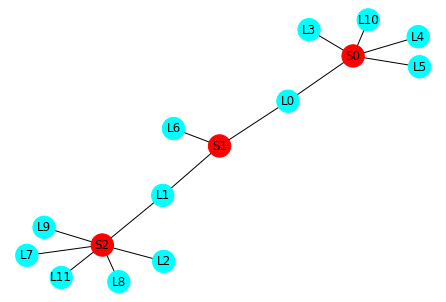

In [215]:
nviz.plot_soma_limb_concept_network(neuron_obj)

In [216]:
neuron_obj.calculate_new_width(no_spines=False,
                                       distance_by_mesh_center=True,
                                       summary_measure="median")

Working on limb L0 branch 6
Working on limb L0 branch 5
Working on limb L0 branch 7
Assigning the old width calculation because no valid new widths
Working on limb L0 branch 184
Working on limb L0 branch 185
Working on limb L0 branch 4
Working on limb L0 branch 8
Assigning the old width calculation because no valid new widths
Working on limb L0 branch 183
Working on limb L0 branch 186
Working on limb L0 branch 1
Working on limb L0 branch 187
Working on limb L0 branch 2
Working on limb L0 branch 25
Working on limb L0 branch 23
Working on limb L0 branch 220
Working on limb L0 branch 221
Working on limb L0 branch 222
Working on limb L0 branch 182
Working on limb L0 branch 188
Working on limb L0 branch 0
Working on limb L0 branch 49
Working on limb L0 branch 3
Working on limb L0 branch 226
Working on limb L0 branch 10
Working on limb L0 branch 11
Working on limb L0 branch 48
Working on limb L0 branch 68
Working on limb L0 branch 9
Working on limb L0 branch 15
Working on limb L0 branch 16
W

Working on limb L1 branch 4
Working on limb L1 branch 6
Working on limb L1 branch 3
Working on limb L1 branch 56
Working on limb L1 branch 21
Working on limb L1 branch 25
Working on limb L1 branch 1
Working on limb L1 branch 5
Working on limb L1 branch 12
Working on limb L1 branch 50
Working on limb L1 branch 20
Working on limb L1 branch 24
Working on limb L1 branch 48
Working on limb L1 branch 49
Working on limb L1 branch 11
Working on limb L1 branch 45
Working on limb L1 branch 52
Working on limb L1 branch 53
Working on limb L1 branch 46
Working on limb L1 branch 47
Working on limb L1 branch 13
Working on limb L1 branch 51
Working on limb L1 branch 54
Working on limb L1 branch 55
Working on limb L1 branch 33
Working on limb L1 branch 34
Working on limb L1 branch 32
Working on limb L1 branch 35
Working on limb L1 branch 31
Working on limb L1 branch 36
Working on limb L1 branch 15
Working on limb L1 branch 16
Working on limb L1 branch 27
Working on limb L1 branch 30
Working on limb L1 

In [223]:
curr_df = su.decompress_pickle("curr_df")

In [227]:
curr_df

,limb,node,median_mesh_center,n_faces_branch
0,L0,6,908.178860,404
1,L0,5,349.165419,11434
2,L0,7,460.052741,6
3,L0,184,270.094784,4226
4,L0,185,254.371528,629
...,...,...,...,...
375,L8,7,66.748064,205
376,L9,1,646.822564,3010
377,L9,0,429.335329,3670
378,L9,2,273.133383,2828


In [ ]:
calculate_new_width(no_spines=False,
                   distance_by_mesh_center=True,
                   summary_measure="median")

In [230]:
curr_df[curr_df["median_mesh_center"].isnull()]

,limb,node,median_mesh_center,n_faces_branch
254,L10,2,NaN,29


In [239]:
x = np.array([5,6,np.nan,7])

In [242]:
np.isnan(x)

array([False, False,  True, False])

In [245]:
np.isnan(np.nan)

True

In [241]:
x[np.isnan(x)]

array([nan])

In [238]:
neuron_obj[10][2].width

nan

In [237]:
import width_utils as wu
wu.calculate_new_width(neuron_obj[10][2], 
                                          skeleton_segment_size = 1000,
                                           width_segment_size=None,
                                          distance_by_mesh_center=True,
                                          no_spines=False,
                                          summary_measure="median",
                                          return_average=True,
                                          print_flag=False)

Assigning the old width calculation because no valid new widths


(array([nan, nan, nan]), nan)

In [236]:
neuron_obj[10][2].width_new["median_mesh_center"]

nan

In [232]:
nviz.visualize_neuron(neuron_obj,
                      visualize_type=["mesh","skeleton"],
                     limb_branch_dict=dict(L10=[2]))


 Working on visualization type: mesh

 Working on visualization type: skeleton


In [222]:
import neuron_searching as ns
ns = reload(ns)
neuron_obj.calculate_spines()

query = median_mesh_center > 200 and n_faces_branch>100
smoothness_threshold = 0.08
The median_mesh_center was requested and HAS already been calculated
functions_list = [<function median_mesh_center at 0x7f0291536950>, <function n_faces_branch at 0x7f0291f30158>]
Number of nans = limb                  0
node                  0
median_mesh_center    1
n_faces_branch        0
dtype: int64
Saved object at /notebooks/Platinum_Decomp_Fusion/curr_df.pbz2
File size is 0.005979 MB


Exception: Some fo the data in the dataframe were incomplete

In [214]:
nviz.visualize_neuron(neuron_obj,
                      visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")


 Working on visualization type: mesh

 Working on visualization type: skeleton


# Debugging the Limb error

In [184]:


soma_touching_vertices_dict = None
distance_by_mesh_center=True #how the distance is calculated for mesh correspondence
meshparty_segment_size = 100
meshparty_n_surface_downsampling = 2
combine_close_skeleton_nodes=True
combine_close_skeleton_nodes_threshold=700
filter_end_node_length=4001
use_meshafterparty=True
perform_cleaning_checks = True

#for controlling the pieces processed by MAP
width_threshold_MAP = 450
size_threshold_MAP = 1000

#parameters for MP skeletonization,

#Parameters for setting how the MAP skeletonization takes place
use_surface_after_CGAL=False
surface_reconstruction_size = 500

#parametrers for stitching the MAP and MP pieces together
move_MAP_stitch_to_end_or_branch = True
distance_to_move_point_threshold=500

#concept_network parameters
run_concept_network_checks = True
return_concept_network = True
return_concept_network_starting_info=False

#printing controls
verbose = True
print_fusion_steps=True


mesh=limb_mesh_mparty
soma_touching_vertices_dict =  piece_to_soma_touching_vertices[curr_limb_idx]
return_concept_network = False
return_concept_network_starting_info=True
width_threshold_MAP=500
size_threshold_MAP=2000
surface_reconstruction_size=1000

In [203]:
from preprocessing_vp2 import *

curr_limb_time = time.time()
    
limb_mesh_mparty = mesh


#will store a list of all the endpoints tha tmust be kept:
limb_to_endpoints_must_keep_list = []
limb_to_soma_touching_vertices_list = []

# --------------- Part 1 and 2: Getting Border Vertices and Setting the Root------------- #
fusion_time = time.time()
#will eventually get the current root from soma_to_piece_touching_vertices[i]
if not soma_touching_vertices_dict is None:
    root_curr = soma_touching_vertices_dict[list(soma_touching_vertices_dict.keys())[0]][0][0]
else:
    root_curr = None

if print_fusion_steps:
    print(f"Time for preparing soma vertices and root: {time.time() - fusion_time }")
    fusion_time = time.time()

# --------------- Part 3: Meshparty skeletonization and Decomposition ------------- #
sk_meshparty_obj = m_sk.skeletonize_mesh_largest_component(limb_mesh_mparty,
                                                        root=root_curr,
                                                          filter_mesh=False)

if print_fusion_steps:
    print(f"Time for 1st pass MP skeletonization: {time.time() - fusion_time }")
    fusion_time = time.time()

(segment_branches, #skeleton branches
divided_submeshes, divided_submeshes_idx, #mesh correspondence (mesh and indices)
segment_widths_median) = m_sk.skeleton_obj_to_branches(sk_meshparty_obj,
                                                      mesh = limb_mesh_mparty,
                                                      meshparty_segment_size=meshparty_segment_size)


if print_fusion_steps:
    print(f"Decomposing first pass: {time.time() - fusion_time }")
    fusion_time = time.time()


if use_meshafterparty:
    print("Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence")
    # --------------- Part 4: Find Individual Branches that could be MAP processed because of width ------------- #
    #gettin the branches that should be passed through MAP skeletonization
    pieces_above_threshold = np.where(segment_widths_median>width_threshold_MAP)[0]

    #getting the correspondnece info for those MAP qualifying
    width_large = segment_widths_median[pieces_above_threshold]
    sk_large = [segment_branches[k] for k in pieces_above_threshold]
    mesh_large_idx = [divided_submeshes_idx[k] for k in pieces_above_threshold]
else:
    print("Only Using MeshParty Skeletonization and Mesh Correspondence")
    mesh_large_idx = []
    width_large = []
    sk_large = []



mesh_pieces_for_MAP = []
mesh_pieces_for_MAP_face_idx = []


if len(mesh_large_idx) > 0: #will only continue processing if found MAP candidates

    # --------------- Part 5: Find mesh connectivity and group MAP branch candidates into MAP sublimbs ------------- #
    print(f"Found len(mesh_large_idx) MAP candidates: {[len(k) for k in mesh_large_idx]}")

    #finds the connectivity edges of all the MAP candidates
    mesh_large_connectivity = tu.mesh_list_connectivity(meshes = mesh_large_idx,
                            main_mesh = limb_mesh_mparty,
                            print_flag = False)
    if print_fusion_steps:
        print(f"mesh_large_connectivity: {time.time() - fusion_time }")
        fusion_time = time.time()
    """
    --------------- Grouping MAP candidates ----------------
    Purpose: Will see what mesh pieces should be grouped together
    to pass through CGAL skeletonization


    Pseudocode: 
    1) build a networkx graph with all nodes for mesh_large_idx indexes
    2) Add the edges
    3) Find the connected components
    4) Find sizes of connected components
    5) For all those connected components that are of a large enough size, 
    add the mesh branches and skeletons to the final list


    """
    G = nx.Graph()
    G.add_nodes_from(np.arange(len(mesh_large_idx)))
    G.add_edges_from(mesh_large_connectivity)
    conn_comp = list(nx.connected_components(G))

    filtered_pieces = []

    sk_large_size_filt = []
    mesh_large_idx_size_filt = []
    width_large_size_filt = []

    for cc in conn_comp:
        total_cc_size = np.sum([len(mesh_large_idx[k]) for k in cc])
        if total_cc_size>size_threshold_MAP:
            #print(f"cc ({cc}) passed the size threshold because size was {total_cc_size}")
            filtered_pieces.append(pieces_above_threshold[list(cc)])

    if print_fusion_steps:
        print(f"Finding MAP candidates connected components: {time.time() - fusion_time }")
        fusion_time = time.time()

    #filtered_pieces: will have the indexes of all the branch candidates that should  be 
    #grouped together and passed through MAP skeletonization

    if len(filtered_pieces) > 0:
        # --------------- Part 6: If Found MAP sublimbs, Get the meshes and mesh_idxs of the sublimbs ------------- #
        print(f"len(filtered_pieces) = {len(filtered_pieces)}")
        #all the pieces that will require MAP mesh correspondence and skeletonization
        #(already organized into their components)
        mesh_pieces_for_MAP = [limb_mesh_mparty.submesh([np.concatenate(divided_submeshes_idx[k])],append=True,repair=False) for k in filtered_pieces]
        mesh_pieces_for_MAP_face_idx = [np.concatenate(divided_submeshes_idx[k]) for k in filtered_pieces]



        """
        Old Way: Finding connectivity of pieces through
        mesh_idx_MP = [divided_submeshes_idx[k] for k in pieces_idx_MP]

        mesh_large_connectivity_MP = tu.mesh_list_connectivity(meshes = mesh_idx_MP,
                                main_mesh = limb_mesh_mparty,
                                print_flag = False)

        New Way: going to use skeleton connectivity to determine
        connectivity of pieces

        Pseudocode: 
        1)

        """
        # --------------- Part 7: If Found MAP sublimbs, Get the meshes and mesh_idxs of the sublimbs ------------- #
        # ********* if there are no pieces leftover then will automatically make all the lists below just empty (don't need to if.. else.. the case)****
        pieces_idx_MP = np.setdiff1d(np.arange(len(divided_submeshes_idx)),np.concatenate(filtered_pieces))

        skeleton_MP = [segment_branches[k] for k in pieces_idx_MP]
        skeleton_connectivity_MP = sk.skeleton_list_connectivity(
                                        skeletons=skeleton_MP
                                        )
        if print_fusion_steps:
            print(f"skeleton_connectivity_MP : {time.time() - fusion_time }")
            fusion_time = time.time()

        G = nx.Graph()
        G.add_nodes_from(np.arange(len(skeleton_MP)))
        G.add_edges_from(skeleton_connectivity_MP)
        sublimbs_MP = list(nx.connected_components(G))
        sublimbs_MP_orig_idx = [pieces_idx_MP[list(k)] for k in sublimbs_MP]


        #concatenate into sublimbs the skeletons and meshes
        sublimb_mesh_idx_branches_MP = [divided_submeshes_idx[k] for k in sublimbs_MP_orig_idx]
        sublimb_mesh_branches_MP = [[limb_mesh_mparty.submesh([ki],append=True,repair=False)
                                    for ki in k] for k in sublimb_mesh_idx_branches_MP]
        sublimb_meshes_MP = [limb_mesh_mparty.submesh([np.concatenate(k)],append=True,repair=False)
                                                     for k in sublimb_mesh_idx_branches_MP]
        sublimb_meshes_MP_face_idx = [np.concatenate(k)
                                                     for k in sublimb_mesh_idx_branches_MP]
        sublimb_skeleton_branches = [segment_branches[k] for k in sublimbs_MP_orig_idx]
        widths_MP = [segment_widths_median[k] for k in sublimbs_MP_orig_idx]

        if print_fusion_steps:
            print(f"Grouping MP Sublimbs by Graph: {time.time() - fusion_time }")
            fusion_time = time.time()


# else: #if no pieces were determine to need MAP processing
#     print("No MAP processing needed: just returning the Meshparty skeletonization and mesh correspondence")
#     raise Exception("Returning MP correspondence")


# nviz.plot_objects(main_mesh=tu.combine_meshes([limb_mesh_mparty,current_neuron["S0"].mesh]),
#                   main_mesh_color="green",
#     skeletons=sk_large_size_filt,
#      meshes=[limb_mesh_mparty.submesh([k],append=True) for k in mesh_large_idx_size_filt],
#       meshes_colors="red")








# --------------- Part 8: If No MAP sublimbs found, set the MP sublimb lists to just the whole MP branch decomposition ------------- #

#if no sublimbs need to be decomposed with MAP then just reassign all of the previous MP processing to the sublimb_MPs
if len(mesh_pieces_for_MAP) == 0:
    sublimb_meshes_MP = [limb_mesh_mparty] #trimesh pieces that have already been passed through MP skeletonization (may not need)
    # -- the decomposition information ---
    sublimb_mesh_branches_MP = [divided_submeshes] #the mesh branches for all the disconnected sublimbs
    sublimb_mesh_idx_branches_MP = [divided_submeshes_idx] #The mesh branches idx that have already passed through MP skeletonization
    sublimb_skeleton_branches = [segment_branches]#the skeleton bnraches for all the sublimbs
    widths_MP = [segment_widths_median] #the mesh branches widths for all the disconnected groups

    MAP_flag = False
else:
    MAP_flag = True



mesh_pieces_for_MAP #trimesh pieces that should go through CGAL skeletonization
sublimb_meshes_MP #trimesh pieces that have already been passed through MP skeletonization (may not need)

# -- the decomposition information ---
sublimb_mesh_branches_MP #the mesh branches for all the disconnected sublimbs
sublimb_mesh_idx_branches_MP #The mesh branches idx that have already passed through MP skeletonization
sublimb_skeleton_branches #the skeleton bnraches for all the sublimbs
widths_MP #the mesh branches widths for all the disconnected groups

if print_fusion_steps:
    print(f"Divinding into MP and MAP pieces: {time.time() - fusion_time }")
    fusion_time = time.time()



# ------------------- At this point have the correct division between MAP and MP ------------------------

# -------------- Part 9: Doing the MAP decomposition ------------------ #
global_start_time = time.time()
endpoints_must_keep = dict()



limb_correspondence_MAP = dict()

for sublimb_idx,(mesh,mesh_idx) in enumerate(zip(mesh_pieces_for_MAP,mesh_pieces_for_MAP_face_idx)):
    print(f"--- Working on MAP piece {sublimb_idx}---")
    mesh_start_time = time.time()
    curr_soma_to_piece_touching_vertices = filter_soma_touching_vertices_dict_by_mesh(
    mesh = mesh,
    curr_piece_to_soma_touching_vertices = soma_touching_vertices_dict
    )

    if print_fusion_steps:
        print(f"MAP Filtering Soma Pieces: {time.time() - fusion_time }")
        fusion_time = time.time()

    # ---- 0) Generating the Clean skeletons  -------------------------------------------#
    if not curr_soma_to_piece_touching_vertices is None:
        curr_total_border_vertices = dict([(k,np.vstack(v)) for k,v in curr_soma_to_piece_touching_vertices.items()])
    else:
        curr_total_border_vertices = None

    cleaned_branch,curr_limb_endpoints_must_keep = sk.skeletonize_and_clean_connected_branch_CGAL(
        mesh=mesh,
        curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices,
        total_border_vertices=curr_total_border_vertices,
        filter_end_node_length=filter_end_node_length,
        perform_cleaning_checks=perform_cleaning_checks,
        combine_close_skeleton_nodes = combine_close_skeleton_nodes,
        combine_close_skeleton_nodes_threshold=combine_close_skeleton_nodes_threshold,
    use_surface_after_CGAL=use_surface_after_CGAL,
    surface_reconstruction_size=surface_reconstruction_size)

    if not curr_limb_endpoints_must_keep is None:
        limb_to_endpoints_must_keep_list.append(curr_limb_endpoints_must_keep)
        limb_to_soma_touching_vertices_list.append(curr_soma_to_piece_touching_vertices)
    else:
        print("Inside MAP decomposition and curr_limb_endpoints_must_keep was None")

    if len(cleaned_branch) == 0:
        raise Exception(f"Found a zero length skeleton for limb {z} of trmesh {branch}")

    if print_fusion_steps:
        print(f"skeletonize_and_clean_connected_branch_CGAL: {time.time() - fusion_time }")
        fusion_time = time.time()

    # ---- 1) Generating Initial Mesh Correspondence -------------------------------------------#
    start_time = time.time()

    print(f"Working on limb correspondence for #{sublimb_idx} MAP piece")
    local_correspondence = mesh_correspondence_first_pass(mesh=mesh,
                                                         skeleton=cleaned_branch,
                                                         distance_by_mesh_center=distance_by_mesh_center)


    print(f"Total time for decomposition = {time.time() - start_time}")
    if print_fusion_steps:
        print(f"mesh_correspondence_first_pass: {time.time() - fusion_time }")
        fusion_time = time.time()


    #------------- 2) Doing Some checks on the initial corespondence -------- #


    if perform_cleaning_checks:
        check_skeletonization_and_decomp(skeleton=cleaned_branch,
                                        local_correspondence=local_correspondence)

    # -------3) Finishing off the face correspondence so get 1-to-1 correspondence of mesh face to skeletal piece
    local_correspondence_revised = correspondence_1_to_1(mesh=mesh,
                                    local_correspondence=local_correspondence,
                                    curr_limb_endpoints_must_keep=curr_limb_endpoints_must_keep,
                                    curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices)

    # -------3b) Fixing the mesh indices to correspond to the larger mesh as a whole
    for k,v in local_correspondence_revised.items():
        local_correspondence_revised[k]["branch_face_idx"] = mesh_idx[local_correspondence_revised[k]["branch_face_idx"]]

    print(f"Total time for MAP sublimb #{sublimb_idx} mesh processing = {time.time() - mesh_start_time}")

    if print_fusion_steps:
        print(f"correspondence_1_to_1: {time.time() - fusion_time }")
        fusion_time = time.time()

    limb_correspondence_MAP[sublimb_idx] = local_correspondence_revised

print(f"Total time for MAP sublimb processing {time.time() - global_start_time}")





# ----------------- Part 10: Doing the MP Decomposition ---------------------- #




sublimb_meshes_MP #trimesh pieces that have already been passed through MP skeletonization (may not need)
# -- the decomposition information ---
sublimb_mesh_branches_MP #the mesh branches for all the disconnected sublimbs
sublimb_mesh_idx_branches_MP #The mesh branches idx that have already passed through MP skeletonization
sublimb_skeleton_branches #the skeleton bnraches for all the sublimbs
widths_MP #the mesh branches widths for all the disconnected groups

limb_correspondence_MP = dict()

for sublimb_idx,mesh in enumerate(sublimb_meshes_MP):
    print(f"---- Working on MP Decomposition #{sublimb_idx} ----")
    mesh_start_time = time.time()

    if len(sublimb_meshes_MP) == 1 and MAP_flag == False:
        print("Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece ")
        curr_soma_to_piece_touching_vertices = soma_touching_vertices_dict
    else:
        if not soma_touching_vertices_dict is None:
            curr_soma_to_piece_touching_vertices = filter_soma_touching_vertices_dict_by_mesh(
                                                mesh = mesh,
                                                curr_piece_to_soma_touching_vertices = soma_touching_vertices_dict
                                                )
        else:
            curr_soma_to_piece_touching_vertices = None

    if print_fusion_steps:
        print(f"MP filtering soma verts: {time.time() - fusion_time }")
        fusion_time = time.time()

    #creating all of the sublimb groups
    segment_branches = sublimb_skeleton_branches[sublimb_idx]
    whole_sk_MP = sk.stack_skeletons(segment_branches)
    branch = mesh
    divided_submeshes = sublimb_mesh_branches_MP[sublimb_idx]
    divided_submeshes_idx = sublimb_mesh_idx_branches_MP[sublimb_idx]
    segment_widths_median = widths_MP[sublimb_idx]

    if curr_soma_to_piece_touching_vertices is None:
        print(f"Do Not Need to Fix MP Decomposition {sublimb_idx} so just continuing")

    else:
        print(f"Fixing Possible Soma Extension Branch for Sublimb {sublimb_idx}")

        #If there is some soma touching then need to see if have to fix soma extending pieces
        return_info = sk.create_soma_extending_branches(current_skeleton=whole_sk_MP,
                                  skeleton_mesh=branch,
                                  soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices,
                                  return_endpoints_must_keep=True,
                                     return_created_branch_info=True)
        new_sk,endpts,new_branch_info = return_info

        if print_fusion_steps:
            print(f"MP (because soma touching verts) create_soma_extending_branches: {time.time() - fusion_time }")
            fusion_time = time.time()

        no_soma_extension_add = True

        if not endpts is None:
            limb_to_endpoints_must_keep_list.append(endpts)
            limb_to_soma_touching_vertices_list.append(curr_soma_to_piece_touching_vertices)

        for sm_idx in new_branch_info.keys():        
            for b_vert_idx,br_info in enumerate(new_branch_info[sm_idx]):
                if br_info is None:
                    continue
                no_soma_extension_add=False


                #1) Get the newly added branch (and the original vertex which is the first row)
                br_new,sm_bord_verts = br_info["new_branch"],br_info["border_verts"] #this will hold the new branch and the border vertices corresponding to it

                curr_soma_to_piece_touching_vertices_MP = {sm_idx:[sm_bord_verts]}
                endpoints_must_keep_MP = {sm_idx:[br_new[0][1]]}


                orig_vertex = br_new[0][0]
                print(f"orig_vertex = {orig_vertex}")

                #2) Find the branches that have that coordinate (could be multiple)
                match_sk_branches = sk.find_branch_skeleton_with_specific_coordinate(segment_branches,
                    current_coordinate=orig_vertex)

                print(f"match_sk_branches = {match_sk_branches}")



                """ ******************* THIS NEEDS TO BE FIXED WITH THE SAME METHOD OF STITCHING ********************  """
                """
                Pseudocode:
                1) Find if branch point will require split or not
                2) If does require split then split the skeleton
                3) Gather mesh pieces for correspondence and the skeletons
                4) Run the mesh correspondence
                - this case calculate the new widths after run 
                5) Replace the old branch parts with the new ones



                """

                stitch_point_on_end_or_branch = find_if_stitch_point_on_end_or_branch(
                                                        matched_branches_skeletons= segment_branches[match_sk_branches],
                                                         stitch_coordinate=orig_vertex,
                                                          verbose=False)


                if not stitch_point_on_end_or_branch:
                    matching_branch_sk = sk.cut_skeleton_at_coordinate(skeleton=segment_branches[match_sk_branches][0],
                                                                      cut_coordinate = orig_vertex)
                else:
                    matching_branch_sk = segment_branches[match_sk_branches]


                #3) Find the mesh and skeleton of the winning branch
                matching_branch_meshes = np.array(divided_submeshes)[match_sk_branches]
                matching_branch_mesh_idx = np.array(divided_submeshes_idx)[match_sk_branches]
                extend_soma_mesh_idx = np.concatenate(matching_branch_mesh_idx)
                extend_soma_mesh = limb_mesh_mparty.submesh([extend_soma_mesh_idx ],append=True,repair=False)

                #4) Add newly created branch to skeleton and divide the skeleton into branches (could make 2 or 3)
                #extended_skeleton_to_soma = sk.stack_skeletons([list(matching_branch_sk),br_new])

                sk.check_skeleton_connected_component(sk.stack_skeletons(list(matching_branch_sk) + [br_new]))

                #5) Run Adaptive mesh correspondnece using branches and mesh
                local_correspondnece_MP = mesh_correspondence_first_pass(mesh=extend_soma_mesh,
                                                                         skeleton_branches = list(matching_branch_sk) + [br_new]
                                              #skeleton=extended_skeleton_to_soma
                                                                        )

                local_correspondence_revised = correspondence_1_to_1(mesh=extend_soma_mesh,
                                                            local_correspondence=local_correspondnece_MP,
                                                            curr_limb_endpoints_must_keep=endpoints_must_keep_MP,
                                                            curr_soma_to_piece_touching_vertices=curr_soma_to_piece_touching_vertices_MP)

                # All the things that should be revised:
            #     segment_branches, #skeleton branches
            #     divided_submeshes, divided_submeshes_idx, #mesh correspondence (mesh and indices)
            #     segment_widths_median


                new_submeshes = [k["branch_mesh"] for k in local_correspondence_revised.values()]
                new_submeshes_idx = [extend_soma_mesh_idx[k["branch_face_idx"]] for k in local_correspondence_revised.values()]
                new_skeletal_branches = [k["branch_skeleton"] for k in local_correspondence_revised.values()]

                #calculate the new width
                ray_inter = tu.ray_pyembree.RayMeshIntersector(limb_mesh_mparty)
                new_widths = []
                for new_s_idx in new_submeshes_idx:
                    curr_ray_distance = tu.ray_trace_distance(mesh=limb_mesh_mparty, 
                                        face_inds=new_s_idx,
                                       ray_inter=ray_inter)
                    new_widths.append(np.median(curr_ray_distance[curr_ray_distance!=0]))


                #6) Remove the original branch and mesh correspondence and replace with the multiples
                segment_branches_old = copy.deepcopy(segment_branches)
                segment_branches = np.delete(segment_branches,match_sk_branches,axis=0)
                segment_branches = np.append(segment_branches,new_skeletal_branches,axis=0)

                divided_submeshes = np.delete(divided_submeshes,match_sk_branches,axis=0)
                divided_submeshes = np.append(divided_submeshes,new_submeshes,axis=0)

                divided_submeshes_idx = np.delete(divided_submeshes_idx,match_sk_branches,axis=0)
                divided_submeshes_idx = np.append(divided_submeshes_idx,new_submeshes_idx,axis=0)

                segment_widths_median = np.delete(segment_widths_median,match_sk_branches)
                segment_widths_median = np.append(segment_widths_median,new_widths,axis=0)

                sk.check_skeleton_connected_component(sk.stack_skeletons(segment_branches))
                print("checked segment branches after soma add on")
                return_find = sk.find_branch_skeleton_with_specific_coordinate(segment_branches,
                                             orig_vertex)



                """ ******************* END OF HOW CAN DO STITCHING ********************  """




        if no_soma_extension_add:
            print("No soma extending branch was added for this sublimb even though it had a soma border (means they already existed)")

        if print_fusion_steps:
            print(f"MP (because soma touching verts) soma extension add: {time.time() - fusion_time }")
            fusion_time = time.time()

    #building the limb correspondence
    limb_correspondence_MP[sublimb_idx] = dict()

    for zz,b_sk in enumerate(segment_branches):
        limb_correspondence_MP[sublimb_idx][zz] = dict(
            branch_skeleton = b_sk,
            width_from_skeleton = segment_widths_median[zz],
            branch_mesh = divided_submeshes[zz],
            branch_face_idx = divided_submeshes_idx[zz]
            )





# ------------------------------------- Part C: Will make sure the correspondences can all be stitched together --------------- #

# Only want to perform this step if both MP and MAP pieces
if len(limb_correspondence_MAP)>0 and len(limb_correspondence_MP)>0:

    # -------------- Part 11: Getting Sublimb Mesh and Skeletons and Gets connectivitiy by Mesh -------#
    # -------------(filtering connections to only MP to MAP edges)--------------- #

    # ---- Doing the mesh connectivity ---------#
    sublimb_meshes_MP = []
    sublimb_skeletons_MP = []

    for sublimb_key,sublimb_v in limb_correspondence_MP.items():
        sublimb_meshes_MP.append(tu.combine_meshes([branch_v["branch_mesh"] for branch_v in sublimb_v.values()]))
        sublimb_skeletons_MP.append(sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in sublimb_v.values()]))

    sublimb_meshes_MAP = []
    sublimb_skeletons_MAP = []

    for sublimb_key,sublimb_v in limb_correspondence_MAP.items():
        sublimb_meshes_MAP.append(tu.combine_meshes([branch_v["branch_mesh"] for branch_v in sublimb_v.values()]))
        sublimb_skeletons_MAP.append(sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in sublimb_v.values()]))



    mesh_conn,mesh_conn_vertex_groups = tu.mesh_list_connectivity(meshes = sublimb_meshes_MP + sublimb_meshes_MAP,
                                        main_mesh = limb_mesh_mparty,
                                        min_common_vertices=1,
                                        return_vertex_connection_groups=True,
                                        return_largest_vertex_connection_group=True,
                                        print_flag = False)
    mesh_conn_old = copy.deepcopy(mesh_conn)



    #check that every MAP piece mapped to a MP piece
    mesh_conn_filt = []
    mesh_conn_vertex_groups_filt = []
    for j,(m1,m2) in enumerate(mesh_conn):
        if m1 < len(sublimb_meshes_MP) and m2 >=len(sublimb_meshes_MP):
            mesh_conn_filt.append([m1,m2])
            mesh_conn_vertex_groups_filt.append(mesh_conn_vertex_groups[j])
    mesh_conn_filt = np.array(mesh_conn_filt)

    mesh_conn = mesh_conn_filt
    mesh_conn_vertex_groups = mesh_conn_vertex_groups_filt

    #check that the mapping should create only one connected component
    G = nx.from_edgelist(mesh_conn)



    try:
        if len(G) != len(sublimb_meshes_MP) + len(sublimb_meshes_MAP):
            raise Exception("Number of nodes in mesh connectivity graph is not equal to number of  MAP and MP sublimbs")

        connect_comp = list(nx.connected_components(G))
        if len(connect_comp)>1:
            raise Exception(f"Mesh connectivity was not one component, instead it was ({len(connect_comp)}): {connect_comp} ")
    except:
        print(f"mesh_conn_filt = {mesh_conn_filt}")
        print(f"mesh_conn_old = {mesh_conn_old}")
        mesh_conn_adjusted = np.vstack([mesh_conn[:,0],mesh_conn[:,1]-len(sublimb_meshes_MP)]).T
        print(f"mesh_conn_adjusted = {mesh_conn_adjusted}")
        print(f"len(sublimb_meshes_MP) = {len(sublimb_meshes_MP)}")
        print(f"len(sublimb_meshes_MAP) = {len(sublimb_meshes_MAP)}")
        meshes = sublimb_meshes_MP + sublimb_meshes_MAP
        #su.compressed_pickle(meshes,"meshes")
        su.compressed_pickle(sublimb_meshes_MP,"sublimb_meshes_MP")
        su.compressed_pickle(sublimb_meshes_MAP,"sublimb_meshes_MAP")
        su.compressed_pickle(limb_mesh_mparty,"limb_mesh_mparty")
        su.compressed_pickle(sublimb_skeletons_MP,"sublimb_skeletons_MP")
        su.compressed_pickle(sublimb_skeletons_MAP,"sublimb_skeletons_MAP")


        raise Exception("Something went wrong in the connectivity")


    #adjust the connection indices for MP and MAP indices
    mesh_conn_adjusted = np.vstack([mesh_conn[:,0],mesh_conn[:,1]-len(sublimb_meshes_MP)]).T






    """
    Pseudocode:
    For each connection edge:
        For each vertex connection group:
            1) Get the endpoint vertices of the MP skeleton
            2) Find the closest endpoint vertex to the vertex connection group (this is MP stitch point)
            3) Find the closest skeletal point on MAP pairing (MAP stitch) 
            4) Find the branches that have that MAP stitch point:
            5A) If the number of branches corresponding to stitch point is multipled
                --> then we are stitching at a branching oint
                i) Just add the skeletal segment from MP_stitch to MAP stitch to the MP skeletal segment
                ii) 

    """

    # -------------- STITCHING PHASE -------#
    for (MP_idx,MAP_idx),v_g in zip(mesh_conn_adjusted,mesh_conn_vertex_groups):
        print(f"\n---- Working on {(MP_idx,MAP_idx)} connection-----")

        """
        This old way of getting the endpoints was not good because could possibly just need
        a stitching done between original branch junction

        skeleton_MP_graph = sk.convert_skeleton_to_graph(curr_skeleton_MP)
        endpoint_nodes = xu.get_nodes_of_degree_k(skeleton_MP_graph,1)
        endpoint_nodes_coordinates = xu.get_node_attributes(skeleton_MP_graph,node_list=endpoint_nodes)
        """


        # -------------- Part 12: Find the MP and MAP stitching point and branches that contain the stitching point-------#


        #getting the skeletons that should be stitched
        curr_skeleton_MP = sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in limb_correspondence_MP[MP_idx].values()])
        curr_skeleton_MAP = sk.stack_skeletons([branch_v["branch_skeleton"] for branch_v in limb_correspondence_MAP[MAP_idx].values()])

        #1) Get the endpoint vertices of the MP skeleton branches (so every endpoint or high degree node)
        #(needs to be inside loop because limb correspondence will change)
        curr_MP_branch_skeletons = [limb_correspondence_MP[MP_idx][k]["branch_skeleton"] for k in np.sort(list(limb_correspondence_MP[MP_idx].keys()))]
        endpoint_nodes_coordinates = np.array([sk.find_branch_endpoints(k) for k in curr_MP_branch_skeletons])
        endpoint_nodes_coordinates = np.unique(endpoint_nodes_coordinates.reshape(-1,3),axis=0)

        #2) Find the closest endpoint vertex to the vertex connection group (this is MP stitch point)
        av_vert = np.mean(v_g,axis=0)
        winning_vertex = endpoint_nodes_coordinates[np.argmin(np.linalg.norm(endpoint_nodes_coordinates-av_vert,axis=1))]
        print(f"winning_vertex = {winning_vertex}")


        #2b) Find the branch points where the winning vertex is located
        MP_branches_with_stitch_point = sk.find_branch_skeleton_with_specific_coordinate(
            divded_skeleton=curr_MP_branch_skeletons,
            current_coordinate = winning_vertex
        )
        print(f"MP_branches_with_stitch_point = {MP_branches_with_stitch_point}")


        #3) Find the closest skeletal point on MAP pairing (MAP stitch)
        MAP_skeleton_coords = np.unique(curr_skeleton_MAP.reshape(-1,3),axis=0)
        MAP_stitch_point = MAP_skeleton_coords[np.argmin(np.linalg.norm(MAP_skeleton_coords-winning_vertex,axis=1))]


        #3b) Consider if the stitch point is close enough to end or branch node in skeleton:
        # and if so then reassign
        if move_MAP_stitch_to_end_or_branch:
            MAP_stitch_point_new,change_status = sk.move_point_to_nearest_branch_end_point_within_threshold(
                                                    skeleton=curr_skeleton_MAP,
                                                    coordinate=MAP_stitch_point,
                                                    distance_to_move_point_threshold = distance_to_move_point_threshold,
                                                    verbose=True

                                                    )
            MAP_stitch_point=MAP_stitch_point_new


        #4) Find the branches that have that MAP stitch point:
        curr_MAP_branch_skeletons = [limb_correspondence_MAP[MAP_idx][k]["branch_skeleton"]
                                             for k in np.sort(list(limb_correspondence_MAP[MAP_idx].keys()))]

        MAP_branches_with_stitch_point = sk.find_branch_skeleton_with_specific_coordinate(
            divded_skeleton=curr_MAP_branch_skeletons,
            current_coordinate = MAP_stitch_point
        )



        MAP_stitch_point_on_end_or_branch = False
        if len(MAP_branches_with_stitch_point)>1:
            MAP_stitch_point_on_end_or_branch = True
        elif len(MAP_branches_with_stitch_point)==1:
            if len(nu.matching_rows(sk.find_branch_endpoints(curr_MAP_branch_skeletons[MAP_branches_with_stitch_point[0]]),
                                    MAP_stitch_point))>0:
                MAP_stitch_point_on_end_or_branch=True
        else:
            raise Exception("No matching MAP values")


        print(f"MAP_branches_with_stitch_point = {MAP_branches_with_stitch_point}")
        print(f"MAP_stitch_point_on_end_or_branch = {MAP_stitch_point_on_end_or_branch}")








        # ------------------------- This part does the stitching -------------------- #


        """
        Pseudocode:
        1) For all MP branches
            a) Get neighbor coordinates to MP stitch points
            b) Delete the MP Stitch points on each 
            c) Add skeleton segment from neighbor to MAP stitch point
        2) Get skeletons and meshes from MP and MAP pieces
        3) Run mesh correspondence to get new meshes and mesh_idx and widths
        4a) If MAP_stitch_point_on_end_or_branch is False
        - Delete the old MAP branch parts and replace with new MAP ones
        4b) Revise the meshes,  mesh_idx, and widths of the MAP pieces
        5) Revise the meshes,  mesh_idx, and widths of the MP pieces


        """

        # -------------- Part 13: Will Adjust the MP branches that have the stitch point so extends to the MAP stitch point -------#
        curr_MP_sk = []
        for b_idx in MP_branches_with_stitch_point:
            c_sk = curr_MP_branch_skeletons[b_idx]
            print(f"\n\nWorking on branch {b_idx} with shape {c_sk.shape}")
            #a) Get neighbor coordinates to MP stitch points
            MP_stitch_branch_graph = sk.convert_skeleton_to_graph(curr_MP_branch_skeletons[c_sk])
            stitch_node = xu.get_nodes_with_attributes_dict(MP_stitch_branch_graph,dict(coordinates=winning_vertex))[0]
            stitch_neighbors = xu.get_neighbors(MP_stitch_branch_graph,stitch_node)

            print(f"stitch_node = {stitch_node}")
            print(f"stitch_neighbors = {stitch_neighbors}")
            
            if len(stitch_neighbors) != 1:
                raise Exception("Not just one neighbor for stitch point of MP branch")
            keep_neighbor = stitch_neighbors[0]  
            keep_neighbor_coordinates = xu.get_node_attributes(MP_stitch_branch_graph,node_list=[keep_neighbor])[0]
            print(f"keep_neighbor = {keep_neighbor}, with coordinate = {keep_neighbor_coordinates}")
            
            #b) Delete the MP Stitch points on each 
            MP_stitch_branch_graph.remove_node(stitch_node)

            """ Old way that does not do smoothing

            #c) Add skeleton segment from neighbor to MAP stitch point
            new_node_name = np.max(MP_stitch_branch_graph.nodes())+1

            MP_stitch_branch_graph.add_nodes_from([(int(new_node_name),{"coordinates":MAP_stitch_point})])
            MP_stitch_branch_graph.add_weighted_edges_from([(keep_neighbor,new_node_name,np.linalg.norm(MAP_stitch_point - keep_neighbor_coordinates))])

            new_MP_skeleton = sk.convert_graph_to_skeleton(MP_stitch_branch_graph)

            """
            try:
                if len(MP_stitch_branch_graph)>1:
                    new_MP_skeleton = sk.add_and_smooth_segment_to_branch(skeleton=sk.convert_graph_to_skeleton(MP_stitch_branch_graph),
                                                    skeleton_stitch_point=keep_neighbor_coordinates,
                                                     new_stitch_point=MAP_stitch_point)
                else:
                    print("Not even attempting smoothing segment because once keep_neighbor_coordinates")
                    new_MP_skeleton = np.vstack([keep_neighbor_coordinates,MAP_stitch_point]).reshape(-1,2,3)
            except:
                su.compressed_pickle(MP_stitch_branch_graph,"MP_stitch_branch_graph")
                su.compressed_pickle(keep_neighbor_coordinates,"keep_neighbor_coordinates")
                su.compressed_pickle(MAP_stitch_point,"MAP_stitch_point")


                Exception("Something went wrong with add_and_smooth_segment_to_branch")





            #smooth over the new skeleton
            new_MP_skeleton_smooth = sk.resize_skeleton_branch(new_MP_skeleton,
                                                              segment_width=meshparty_segment_size)

            curr_MP_sk.append(new_MP_skeleton_smooth)



        #2) Get skeletons and meshes from MP and MAP pieces
        curr_MAP_sk = [limb_correspondence_MAP[MAP_idx][k]["branch_skeleton"] for k in MAP_branches_with_stitch_point]

        #2.1) Going to break up the MAP skeleton if need be
        """
        Pseudocode:
        a) check to see if it needs to be broken up
        If it does:
        b) Convert the skeleton into a graph
        c) Find the node of the MAP stitch point (where need to do the breaking)
        d) Find the degree one nodes
        e) For each degree one node:
        - Find shortest path from stitch node to end node
        - get a subgraph from that path
        - convert graph to a skeleton and save as new skeletons

        """
        # -------------- Part 14: Breaks Up MAP skeleton into 2 pieces if Needs (because MAP stitch point not on endpoint or branch point)  -------#

        #a) check to see if it needs to be broken up
        if not MAP_stitch_point_on_end_or_branch:
            if len(curr_MAP_sk) > 1:
                raise Exception(f"There was more than one skeleton for MAP skeletons even though MAP_stitch_point_on_end_or_branch = {MAP_stitch_point_on_end_or_branch}")


            skeleton_to_cut = curr_MAP_sk[0]
            curr_MAP_sk = sk.cut_skeleton_at_coordinate(skeleton=skeleton_to_cut,
                                                        cut_coordinate=MAP_stitch_point)


        # -------------- Part 15: Gets all of the skeletons and Mesh to divide u and does mesh correspondence -------#
        # ------------- revise IDX so still references the whole limb mesh -----------#
        curr_MAP_meshes_idx = [limb_correspondence_MAP[MAP_idx][k]["branch_face_idx"] for k in MAP_branches_with_stitch_point]

        curr_MP_sk
        curr_MP_meshes_idx = [limb_correspondence_MP[MP_idx][k]["branch_face_idx"] for k in MP_branches_with_stitch_point]

        stitching_mesh_idx = np.concatenate(curr_MAP_meshes_idx + curr_MP_meshes_idx)
        stitching_mesh = limb_mesh_mparty.submesh([stitching_mesh_idx],append=True,repair=False)
        stitching_skeleton_branches = curr_MAP_sk + curr_MP_sk
        """

        ****** NEED TO GET THE RIGHT MESH TO RUN HE IDX ON SO GETS A GOOD MESH (CAN'T BE LIMB_MESH_MPARTY)
        BUT MUST BE THE ORIGINAL MAP MESH

        mesh_pieces_for_MAP
        sublimb_meshes_MP

        mesh_pieces_for_MAP_face_idx
        sublimb_meshes_MP_face_idx

        stitching_mesh = tu.combine_meshes(curr_MAP_meshes + curr_MP_meshes)
        stitching_skeleton_branches = curr_MAP_sk + curr_MP_sk

        """

        #3) Run mesh correspondence to get new meshes and mesh_idx and widths
        local_correspondnece_stitch = mesh_correspondence_first_pass(mesh=stitching_mesh,
                                      skeleton_branches=stitching_skeleton_branches)

        try:

            local_correspondence_stitch_revised = correspondence_1_to_1(mesh=stitching_mesh,
                                                        local_correspondence=local_correspondnece_stitch,
                                                        curr_limb_endpoints_must_keep=None,
                                                        curr_soma_to_piece_touching_vertices=None)
        except:
            su.compressed_pickle(stitching_skeleton_branches,"stitching_skeleton_branches")
            su.compressed_pickle(stitching_mesh,"stitching_mesh")
            su.compressed_pickle(local_correspondnece_stitch,"local_correspondnece_stitch")
            raise Exception("Something went wrong with 1 to 1 correspondence")


        #Need to readjust the mesh correspondence idx
        for k,v in local_correspondence_stitch_revised.items():
            local_correspondence_stitch_revised[k]["branch_face_idx"] = stitching_mesh_idx[local_correspondence_stitch_revised[k]["branch_face_idx"]]




        # -------------- Part 16: Overwrite old branch entries (and add on one new to MAP if required a split) -------#


        #4a) If MAP_stitch_point_on_end_or_branch is False
        #- Delete the old MAP branch parts and replace with new MAP ones
        if not MAP_stitch_point_on_end_or_branch:
            print("Deleting branches from dictionary")
            del limb_correspondence_MAP[MAP_idx][MAP_branches_with_stitch_point[0]]
            #adding the two new branches created from the stitching
            limb_correspondence_MAP[MAP_idx][MAP_branches_with_stitch_point[0]] = local_correspondence_stitch_revised[0]
            limb_correspondence_MAP[MAP_idx][np.max(list(limb_correspondence_MAP[MAP_idx].keys()))+1] = local_correspondence_stitch_revised[1]

            #have to reorder the keys
            #limb_correspondence_MAP[MAP_idx] = dict([(k,limb_correspondence_MAP[MAP_idx][k]) for k in np.sort(list(limb_correspondence_MAP[MAP_idx].keys()))])
            limb_correspondence_MAP[MAP_idx] = gu.order_dict_by_keys(limb_correspondence_MAP[MAP_idx])

        else: #4b) Revise the meshes,  mesh_idx, and widths of the MAP pieces if weren't broken up
            for j,curr_MAP_idx_fixed in enumerate(MAP_branches_with_stitch_point):
                limb_correspondence_MAP[MAP_idx][curr_MAP_idx_fixed] = local_correspondence_stitch_revised[j]

        #5) Revise the meshes,  mesh_idx, and widths of the MP pieces
        for j,curr_MP_idx_fixed in enumerate(MP_branches_with_stitch_point):
            limb_correspondence_MP[MP_idx][curr_MP_idx_fixed] = local_correspondence_stitch_revised[j+len(curr_MAP_sk)]


        print(f" Finished with {(MP_idx,MAP_idx)} \n\n\n")


else:
    print("There were not both MAP and MP pieces so skipping the stitch resolving phase")

print(f"Time for decomp of Limb = {time.time() - curr_limb_time}")
#     # ------------- Saving the MAP and MP Decompositions ---------------- #
#     proper_limb_mesh_correspondence_MAP[curr_limb_idx] = limb_correspondence_MAP
#     proper_limb_mesh_correspondence_MP[curr_limb_idx] = limb_correspondence_MP






# -------------- Part 17: Grouping the MP and MAP Correspondence into one correspondence dictionary -------#
limb_correspondence_individual = dict()
counter = 0

for sublimb_idx,sublimb_branches in limb_correspondence_MAP.items():
    for branch_dict in sublimb_branches.values():
        limb_correspondence_individual[counter]= branch_dict
        counter += 1
for sublimb_idx,sublimb_branches in limb_correspondence_MP.items():
    for branch_dict in sublimb_branches.values():
        limb_correspondence_individual[counter]= branch_dict
        counter += 1


#info that may be used for concept networks
network_starting_info = dict(
            touching_verts_list = limb_to_soma_touching_vertices_list,
            endpoints_must_keep = limb_to_endpoints_must_keep_list
)

if not return_concept_network:
    if return_concept_network_starting_info: #because may want to calculate the concept networks later
        return_value = limb_correspondence_individual,network_starting_info
    else:
        return_value =limb_correspondence_individual
else:
        limb_to_soma_concept_networks = calculate_limb_concept_networks(limb_correspondence_individual,
                                                                        run_concept_network_checks=run_concept_network_checks,
                                                                       **network_starting_info)
        
                    
return_value= limb_correspondence_individual,limb_to_soma_concept_networks



  0%|          | 0/1 [00:00<?, ?it/s]

Time for preparing soma vertices and root: 0.00010752677917480469
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


Time for 1st pass MP skeletonization: 0.12961506843566895
branches_touching_root = [0]
length of Graph = 91
max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0



/meshAfterParty/meshparty_skeletonize.py:888: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])



AFTER face_lookup_resolved_test



Decomposing first pass: 0.1578049659729004
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Divinding into MP and MAP pieces: 0.0009496212005615234
Total time for MAP sublimb processing 0.0004322528839111328
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 0.0013401508331298828
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.0320127010345459
sbv[0].reshape(-1,3) = [[400510.8 692276.6 654658.6]]
closest_sk_pt_coord BEFORE = [399402.92317352 691578.28956197 654323.96564105]
current_skeleton.shape = (90, 2, 3)
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1999.4697543080454
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [399402.92317352 691578.28956197 654323.96564105]
Adding new branch to skeleton
border_average_coordinate = [398414.29333333 693696.6

/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])





--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.5888615888615889
 conflict_indices % = 0.030303030303030304



AFTER face_lookup_resolved_test
Took 0 iterations to expand the label back


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 1 dimension(s)

In [210]:
[k for i,k in enumerate(segment_branches_old) if i not in match_sk_branches]

[]

In [207]:
new_skeletal_branches[1].shape

(70, 2, 3)

array([[[[398532.32385261, 691761.46287233, 652707.8121781 ],
         [398557.20347299, 691718.29131789, 652794.50592833]],

        [[398532.32385261, 691761.46287233, 652707.8121781 ],
         [398509.60636809, 691804.59972953, 652620.50556229]],

        [[398557.20347299, 691718.29131789, 652794.50592833],
         [398584.70465126, 691676.33287551, 652880.98805541]],

        [[398584.70465126, 691676.33287551, 652880.98805541],
         [398614.93896185, 691636.39898148, 652967.50636371]],

        [[398614.93896185, 691636.39898148, 652967.50636371],
         [398648.83376501, 691600.03934332, 653054.27686003]],

        [[398648.83376501, 691600.03934332, 653054.27686003],
         [398686.79002569, 691568.8779333 , 653141.32449219]],

        [[398686.79002569, 691568.8779333 , 653141.32449219],
         [398727.4359853 , 691541.72953423, 653228.45179813]],

        [[398727.4359853 , 691541.72953423, 653228.45179813],
         [398771.33952045, 691519.86663102, 653315.59818

In [193]:
match_sk_branches

[0]

In [201]:
segment_branches_old.shape
result = np.delete(segment_branches_old,0,axis=0)
len(result)

0

In [177]:
stitch_point_on_end_or_branch

False

In [154]:
curr_MP_sk_revised = []
for b_idx in MP_branches_with_stitch_point:
    c_sk = curr_MP_branch_skeletons[b_idx]
    print(f"\n\nWorking on branch {b_idx} with shape {c_sk.shape}")
    #a) Get neighbor coordinates to MP stitch points
    MP_stitch_branch_graph = sk.convert_skeleton_to_graph(c_sk)
    stitch_node = xu.get_nodes_with_attributes_dict(MP_stitch_branch_graph,dict(coordinates=winning_vertex))[0]
    stitch_neighbors = xu.get_neighbors(MP_stitch_branch_graph,stitch_node)

    print(f"stitch_node = {stitch_node}")
    print(f"stitch_neighbors = {stitch_neighbors}")

    if len(stitch_neighbors) != 1:
        raise Exception("Not just one neighbor for stitch point of MP branch")
    keep_neighbor = stitch_neighbors[0]  
    keep_neighbor_coordinates = xu.get_node_attributes(MP_stitch_branch_graph,node_list=[keep_neighbor])[0]
    print(f"keep_neighbor = {keep_neighbor}, with coordinate = {keep_neighbor_coordinates}")

    #b) Delete the MP Stitch points on each 
    MP_stitch_branch_graph.remove_node(stitch_node)

    """ Old way that does not do smoothing

    #c) Add skeleton segment from neighbor to MAP stitch point
    new_node_name = np.max(MP_stitch_branch_graph.nodes())+1

    MP_stitch_branch_graph.add_nodes_from([(int(new_node_name),{"coordinates":MAP_stitch_point})])
    MP_stitch_branch_graph.add_weighted_edges_from([(keep_neighbor,new_node_name,np.linalg.norm(MAP_stitch_point - keep_neighbor_coordinates))])

    new_MP_skeleton = sk.convert_graph_to_skeleton(MP_stitch_branch_graph)

    """
    try:
        if len(MP_stitch_branch_graph)>1:
            new_MP_skeleton = sk.add_and_smooth_segment_to_branch(skeleton=sk.convert_graph_to_skeleton(MP_stitch_branch_graph),
                                            skeleton_stitch_point=keep_neighbor_coordinates,
                                             new_stitch_point=MAP_stitch_point)
        else:
            print("Not even attempting smoothing segment because once keep_neighbor_coordinates")
            new_MP_skeleton = np.vstack([keep_neighbor_coordinates,MAP_stitch_point]).reshape(-1,2,3)
    except:
        su.compressed_pickle(MP_stitch_branch_graph,"MP_stitch_branch_graph")
        su.compressed_pickle(keep_neighbor_coordinates,"keep_neighbor_coordinates")
        su.compressed_pickle(MAP_stitch_point,"MAP_stitch_point")


        raise Exception("Something went wrong with add_and_smooth_segment_to_branch")





    #smooth over the new skeleton
    new_MP_skeleton_smooth = sk.resize_skeleton_branch(new_MP_skeleton,
                                                      segment_width=meshparty_segment_size)

    curr_MP_sk_revised.append(new_MP_skeleton_smooth)




Working on branch 0 with shape (20, 2, 3)
stitch_node = 20
stitch_neighbors = [19]
keep_neighbor = 19, with coordinate = [398344.89985926 695922.85005431 653489.58544469]
Only 2 skeleton nodes so cannot do smoothing


Working on branch 1 with shape (33, 2, 3)
stitch_node = 0
stitch_neighbors = [1]
keep_neighbor = 1, with coordinate = [398539.48096876 695945.47197422 653449.27157824]
Only 2 skeleton nodes so cannot do smoothing


Working on branch 2 with shape (1, 2, 3)
stitch_node = 0
stitch_neighbors = [1]
keep_neighbor = 1, with coordinate = [398713.48305085 695803.2559322  654675.06101695]
Not even attempting smoothing segment because once keep_neighbor_coordinates


In [150]:
keep_neighbor_coordinates

array([398713.48305085, 695803.2559322 , 654675.06101695])

In [152]:
len(MP_stitch_branch_graph)

1

In [140]:
limb_correspondence_MP[0].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141])

In [135]:
len(curr_MP_branch_skeletons)

3

In [117]:
MP_sk_to_stitch = np.array(curr_MP_branch_skeletons)[MP_branches_with_stitch_point]
MP_sk_to_stitch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([array([[[396519.05188109, 695707.96994235, 653962.01770004],
        [396612.55109607, 695717.60281135, 653927.8893956 ]],

       [[396612.55109607, 695717.60281135, 653927.8893956 ],
        [396706.51194747, 695727.81889063, 653895.22735895]],

       [[396706.51194747, 695727.81889063, 653895.22735895],
        [396801.01032369, 695738.57358539, 653864.33410026]],

       [[396801.01032369, 695738.57358539, 653864.33410026],
        [396895.95537377, 695749.62466192, 653834.97013104]],

       [[396895.95537377, 695749.62466192, 653834.97013104],
        [396991.18955403, 695760.82662634, 653806.61124034]],

       [[396991.18955403, 695760.82662634, 653806.61124034],
        [397086.92360657, 695772.16962007, 653780.0344144 ]],

       [[397086.92360657, 695772.16962007, 653780.0344144 ],
        [397182.9226357 , 695783.49245995, 653754.44094627]],

       [[397182.9226357 , 695783.49245995, 653754.44094627],
        [397279.1653129 , 695794.79676821, 653729.75168339]],

 

In [120]:
MP_sk_to_stitch[0].shape,MP_sk_to_stitch[1].shape,MP_sk_to_stitch[2].shape

((20, 2, 3), (33, 2, 3), (1, 2, 3))

In [123]:
MAP_stitch_point

array([400197., 692457., 653242.])

In [155]:
nviz.plot_objects(meshes=all_correspondence_mesh,
                 meshes_colors="random",
                 #skeletons=list(MP_sk_to_stitch) + [curr_MAP_branch_skeletons[MAP_branches_with_stitch_point[0]]],
                  #skeletons=np.array(curr_MP_branch_skeletons)[MP_branches_with_stitch_point],
                  skeletons=curr_MP_sk_revised,
                 skeletons_colors="random",
                 scatters=[np.array([MAP_stitch_point,winning_vertex])],
                 scatter_size=1)

/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


In [132]:
nviz.plot_objects(meshes=all_correspondence_mesh,
                 meshes_colors="random",
                 skeletons=[curr_MP_sk[2]],
                 skeletons_colors="random",
                 scatters=[np.array([MAP_stitch_point,winning_vertex])],
                 scatter_size=1)

In [113]:
len(stitching_skeleton_branches)

5

In [111]:
all_correspondence_mesh = [k["correspondence_mesh"] for k in local_correspondnece_stitch.values()]
all_branch_skeleton = [k["branch_skeleton"] for k in local_correspondnece_stitch.values()]

nviz.plot_objects(meshes=all_correspondence_mesh,
                 meshes_colors="random",
                 skeletons=[all_branch_skeleton[3]],
                 skeletons_colors="random")

# Debugging the compartment labeling

In [89]:
curr_limb_mesh = su.decompress_pickle("curr_limb_mesh")
face_lookup = su.decompress_pickle("face_lookup")
no_missing_labels = su.decompress_pickle("no_missing_labels")
max_submesh_threshold = su.decompress_pickle("max_submesh_threshold")

In [82]:
stitching_mesh = su.decompress_pickle("stitching_mesh")
local_correspondnece_stitch = su.decompress_pickle("local_correspondnece_stitch")

In [93]:
local_correspondnece_stitch.keys()

dict_keys([0, 1, 2, 3, 4])

In [87]:

all_correspondence_mesh = [k["correspondence_mesh"] for k in local_correspondnece_stitch.values()]
all_branch_skeleton = [k["branch_skeleton"] for k in local_correspondnece_stitch.values()]

In [98]:
nviz.plot_objects(meshes=all_correspondence_mesh,
                 meshes_colors="random",
                 skeletons=[all_branch_skeleton[4]],
                 skeletons_colors="random")

In [90]:
if len(no_missing_labels) == 0:
    no_missing_labels = list(set(list(itertools.chain.from_iterable(list(face_lookup.values())))))

#get all of the faces that don't have any faces corresponding
empty_indices = np.array([k for k,v in face_lookup.items() if len(v) == 0])

#get all of the faces that don't have any faces corresponding
conflict_indices = np.array([k for k,v in face_lookup.items() if len(v) >= 2])

print(f"empty_indices % = {len(empty_indices)/len(face_lookup.keys())}\n conflict_indices % = {len(conflict_indices)/len(face_lookup.keys())}")



#doing the face coloring (OLD WAY)
##face_coloring = np.array([-1 if len(v) != 1 else v[0] for v in face_lookup.values()])

#doing the face coloring (new way if the keys are unordered)
face_coloring = np.full(len(curr_limb_mesh.faces),-1)
for k,v in face_lookup.items():
    if len(v) == 1:
        face_coloring[k] = v[0]

empty_indices % = 0.3717535086304243
 conflict_indices % = 0.11566381674463623


In [92]:
no_missing_labels

[0, 1, 2, 3, 4]

In [91]:
np.unique(face_coloring)

array([-1,  0,  1,  2])

In [79]:
for v in face_lookup.values():
    if 2 in v and 1 not in v:
        print(v)

In [70]:
nviz.plot_objects(curr_limb_mesh)

/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


In [ ]:
# Looking at the decomposition from MP

In [65]:
sk = reload(sk)
m_sk = reload(m_sk)

print_fusion_steps=True

# --------------- Part 3: Meshparty skeletonization and Decomposition ------------- #
limb_to_endpoints_must_keep_list = []
limb_to_soma_touching_vertices_list = []

# --------------- Part 1 and 2: Getting Border Vertices and Setting the Root------------- #
fusion_time = time.time()
#will eventually get the current root from soma_to_piece_touching_vertices[i]
if not soma_touching_vertices_dict is None:
    root_curr = soma_touching_vertices_dict[list(soma_touching_vertices_dict.keys())[0]][0][0]
else:
    root_curr = None

if print_fusion_steps:
    print(f"Time for preparing soma vertices and root: {time.time() - fusion_time }")
    fusion_time = time.time()

# --------------- Part 3: Meshparty skeletonization and Decomposition ------------- #
sk_meshparty_obj = m_sk.skeletonize_mesh_largest_component(limb_mesh_mparty,
                                                        root=root_curr,
                                                          filter_mesh=False)

if print_fusion_steps:
    print(f"Time for 1st pass MP skeletonization: {time.time() - fusion_time }")
    fusion_time = time.time()

(segment_branches, #skeleton branches
divided_submeshes, divided_submeshes_idx, #mesh correspondence (mesh and indices)
segment_widths_median) = m_sk.skeleton_obj_to_branches(sk_meshparty_obj,
                                                      mesh = limb_mesh_mparty,
                                                      meshparty_segment_size=meshparty_segment_size)



Time for preparing soma vertices and root: 0.00013756752014160156
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:25<00:00, 25.12s/it]

Time for 1st pass MP skeletonization: 27.861298322677612


/meshAfterParty/meshparty_skeletonize.py:888: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array([sk_meshparty_obj.vertices[np.vstack([k[:-1],k[1:]]).T] for k in segments])


branches_touching_root = [16]


/meshAfterParty/meshparty_skeletonize.py:949: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches = np.array(new_segment_branches)


length of Graph = 41389
Working on path [1140. 1150. 1160. 1172. 1179.]
path_degrees = [3, 2, 2, 2, 3]
Working on path [3372. 3375. 3385. 3393. 3402. 3404.]
path_degrees = [3, 2, 2, 2, 2, 3]
Working on path [4213. 4219. 4224. 4230. 4236. 4239.]
path_degrees = [3, 2, 2, 2, 2, 3]
Working on path [4622. 4644. 4657.]
path_degrees = [3, 2, 3]
Working on path [5087. 5088. 5090. 5094. 5097. 5098.]
path_degrees = [3, 2, 2, 2, 2, 3]
Working on path [5659. 5674. 5683.]
path_degrees = [3, 2, 3]
Working on path [41394.  5701.  5720.  5739.  5758.  5790.  5795.]
path_degrees = [4, 2, 2, 2, 2, 2, 3]
Working on path [25272. 25308. 25343. 25369.]
path_degrees = [3, 2, 2, 3]
Working on path [25635. 25682. 25721. 25727.]
path_degrees = [3, 2, 2, 3]
Working on path [36463. 36484. 36505. 36524. 36545. 36567. 36570.]
path_degrees = [3, 2, 2, 2, 2, 2, 3]


/meshAfterParty/meshparty_skeletonize.py:974: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  segment_branches_filtered = np.array(segment_branches_filtered)


max(kept_branches_idx) = 239, len(kept_branches_idx) = 230
empty_indices % = 0.0
 conflict_indices % = 0.012809612409755712


/meshAfterParty/trimesh_utils.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ordered_comp_indices = np.array([k.astype("int") for k in ordered_components])



AFTER face_lookup_resolved_test


/meshAfterParty/trimesh_utils.py:972: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  total_submeshes_idx =np.array(list(total_submeshes_idx.values()))


In [60]:
nviz.plot_objects(skeletons=segment_branches,
                 skeletons_colors="random",
                 scatters=[np.array([sk_1_closest_node,sk_2_closest_node])],
                  scatter_size=0.15)

In [12]:
sublimb_meshes_MP = su.decompress_pickle("sublimb_meshes_MP")
sublimb_meshes_MAP = su.decompress_pickle("sublimb_meshes_MAP")
limb_mesh_mparty = su.decompress_pickle("limb_mesh_mparty")
sublimb_skeletons_MP = su.decompress_pickle("sublimb_skeletons_MP")
sublimb_skeletons_MAP = su.decompress_pickle("sublimb_skeletons_MAP")

In [13]:
sublimb_meshes_MP = np.array(sublimb_meshes_MP)
sublimb_skeletons_MP = np.array(sublimb_skeletons_MP)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [39]:
col = ["red","black"]
nviz.plot_objects(meshes=sublimb_meshes_MP[[0,3]],
                 meshes_colors=col,
                 skeletons=sublimb_skeletons_MP[[0,3]],
                 skeletons_colors=col,
                  scatters=[np.array([sk_1_closest_node,sk_2_closest_node])],
                  scatter_size=0.5
                 )

In [ ]:
from pykdtree.kdtree import KDTree

In [23]:
sk_1,sk_2 = sublimb_skeletons_MP[[0,3]]

In [25]:
sk_1_nodes,_ = sk.convert_skeleton_to_nodes_edges(sk_1)
sk_2_nodes,_ = sk.convert_skeleton_to_nodes_edges(sk_2)

In [28]:
sk_1_kdtree = KDTree(sk_1_nodes)
sk_dist,sk_closest_nodes = sk_1_kdtree.query(sk_2_nodes)

In [36]:
min_index = np.argmin(sk_dist)
sk_1_closest_node = sk_1_nodes[sk_closest_nodes[min_index]]
sk_2_closest_node = sk_2_nodes[min_index]

In [37]:
sk_2_closest_node

array([421577.49895621, 641047.79203307, 652977.18304824])

In [18]:
tot_sk = sk.stack_skeletons(sublimb_skeletons_MP[[0,3]])

In [19]:
nx.number_connected_components(sk.convert_skeleton_to_graph(tot_sk))

2

In [ ]:
import system_utils as su
meshes = su.decompress_pickle("meshes")

sublimb_meshes_MP = meshes[:23]
sublimb_meshes_MAP = meshes[23:]

MP_meshes_total = tu.combine_meshes(MP_meshes)
MP_meshes_total

In [ ]:
limb_mesh_mparty = su.decompress_pickle("limb_mesh_mparty")

In [42]:
mesh_conn

array([[0, 1],
       [0, 2],
       [1, 2],
       [0, 3],
       [1, 3],
       [2, 3]])

In [43]:
sublimb_meshes_MP[[3]]

array([<trimesh.Trimesh(vertices.shape=(22739, 3), faces.shape=(45469, 3))>],
      dtype=object)

In [48]:
mesh_conn

array([[0, 1]])

In [50]:
sublimb_meshes_MP[[3]]

array([<trimesh.Trimesh(vertices.shape=(22739, 3), faces.shape=(45469, 3))>],
      dtype=object)

In [49]:
sublimb_meshes_MP[[3]] + sublimb_meshes_MAP[0:2]

array([<trimesh.Trimesh(vertices.shape=(26936, 3), faces.shape=(53817, 3))>,
       <trimesh.Trimesh(vertices.shape=(69009, 3), faces.shape=(136868, 3))>],
      dtype=object)

In [55]:
mesh_conn,mesh_conn_vertex_groups = tu.mesh_list_connectivity(meshes = list(sublimb_meshes_MP[[3]]) + sublimb_meshes_MAP,
                                            main_mesh = limb_mesh_mparty,
                                            min_common_vertices=1,
                                            return_vertex_connection_groups=True,
                                            return_largest_vertex_connection_group=True,
                                            print_flag = False)

In [54]:
col = ["red","black"]
nviz.plot_objects(meshes=list(sublimb_meshes_MP[[3]]) + sublimb_meshes_MAP[0:2],
                 meshes_colors="random",
                 #skeletons=[sublimb_skeletons_MP[3],sk.stack_skeletons(sublimb_skeletons_MAP)],
                 #skeletons_colors=col,
                  scatters=[np.array([sk_1_closest_node,sk_2_closest_node])],
                  scatter_size=0.5
                 )

In [ ]:
combined_m = tu.combine_meshes(np.array(sublimb_meshes_MP)[[3,0]])
combined_m

In [ ]:
combined_m.merge_vertices()
new_mesh

In [ ]:
nviz.plot_objects(meshes=tu.split(combined_m)[0],
                 meshes_colors="random")

In [ ]:
nviz.plot_objects(#main_mesh=limb_mesh_mparty,
                 meshes=np.array(sublimb_meshes_MP)[[3,0]],
                 meshes_colors=["black","orange"],
)

In [ ]:
soma_mesh_list

In [ ]:
nviz.plot_objects(meshes=soma_mesh_list)

In [ ]:
nviz.plot_objects(meshes=[tu.combine_meshes(k) for k in [MAP_meshes,MP_meshes,soma_mesh_list]],
                 meshes_colors=["black","red","orange"])

# Sending the data to the Neuron Object

In [ ]:
nru = reload(nru)
save_time = time.time()
neuron_obj.save_compressed_neuron(output_folder="/notebooks/test_neurons/Fusion_decomp/",
                                 export_mesh=True,
                                 suppress_output=True)
print(f"Save time = {time.time() - save_time}")

In [ ]:
nru = reload(nru)
reload_time = time.time()
recovered_neuron = nru.decompress_neuron(filepath="./12345_double_soma",
                     original_mesh="./12345_double_soma")
print(f"Save time = {time.time() - reload_time}")

In [ ]:
import neuron_visualizations as nviz
returned_colors = nviz.visualize_neuron(neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict=dict(L6="all"),
                                       return_color_dict=True)